## Investigation of sensitivity per energy bin

* How does R change with cross section?
* What is the most sensitive energy range and angle
* How do observables change for depth, zenith, season
* What absolute R do we expect for the Sibyll2.3c cross section as default value an experiment could observe

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pickle
import numpy as np

import crflux.models as pm
import mceq_underground_helpers_cs as mh
from MCEq.data import InteractionCrossSections
from MCEq.core import MCEqRun
import  mceq_underground_helpers_oneregion as helper

In [3]:
cs_p_values = [1.0,1.01] #[0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]  # List of cross-section values: pion-air
cs_k_values = [1.00]
ptype_values = [2212] 
season_values = ["jan", "apr", "jul"]  #  seasons
e0_values = [2.05,2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85]
e1_values = [2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85,4.95,5.05]
pairwise = True


helper.initialize_flux_dicts(
        ptype_values, cs_p_values, cs_k_values, e0_values, e1_values if 'e1_values' in locals() else [None], pairwise=pairwise
) 

helper.some_function_that_uses_angles()
angles = helper.angles
X = helper.slant_depths[2:-1:4]


Key: (2212, 1.0, 1.0, 2.05, 'inf')
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.05, 2.25)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.15, 2.35)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.25, 2.45)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.35, 2.55)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.45, 2.65)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for seas

In [4]:
plot_dir = '/hetghome/khymon/Plots/cs-analysis/'

In [5]:
# get pion cross section
mceq_instance = MCEqRun(
        interaction_model="SIBYLL23C",
        theta_deg=0.0,
        primary_model=(pm.GlobalSplineFitBeta, None),
        density_model = ('MSIS00_IC',('South Pole','January')),
    )


cs_pion = InteractionCrossSections(mceq_instance._mceq_db, interaction_model="SIBYLL23C").get_cs(211, mbarn=True)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('South Pole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): GlobalSplineFitBeta 


In [6]:
# Load the pickle file - see file with fixed norm 4.05 in same folder, here norm is changed according to current e0
#default order: (str(d), str(cs_p1), str(cs_p2), str(cs_k2), str(ptype), season, str(e0))

# normalization flag
norm = False

if norm:

    with open("/hetghome/khymon/cs-files/R_value_const_pi-air_k-air_sibyll23c_smooth_oneregion_energybin_test.pkl", "rb") as file:
        data = pickle.load(file)

else:
    with open("/hetghome/khymon/cs-files/R_value_const_pi-air_k-air_sibyll23c_smooth_oneregion_energybin_test_nonorm.pkl", "rb") as file:
        data = pickle.load(file)

# Print or inspect the data
print(data)

{('1.5', '1.0', '1.0', '2212', 'jan', '2.05', 'inf'): (array([4.48226310e-05, 4.85627721e-05, 5.28496790e-05, 5.83037731e-05,
       6.49225780e-05, 7.28977514e-05]), array([0.00020249, 0.00054492, 0.0011649 , 0.00211498, 0.0035152 ,
       0.0053082 ]), array([9.07630954e-09, 2.64629279e-08, 6.15645226e-08, 1.23311149e-07,
       2.28215998e-07, 3.86955849e-07])), ('1.5', '1.0', '1.0', '2212', 'apr', '2.05', 'inf'): (array([4.84124814e-05, 5.24411267e-05, 5.70397214e-05, 6.25745447e-05,
       6.96276325e-05, 7.79682006e-05]), array([0.00018474, 0.00049567, 0.00105766, 0.00192373, 0.00318812,
       0.00481121]), array([8.94351900e-09, 2.59932393e-08, 6.03286567e-08, 1.20376599e-07,
       2.21981009e-07, 3.75121348e-07])), ('1.5', '1.0', '1.0', '2212', 'jul', '2.05', 'inf'): (array([5.23442020e-05, 5.63753157e-05, 6.12945583e-05, 6.65843833e-05,
       7.35814095e-05, 8.18216528e-05]), array([0.00015038, 0.00040504, 0.00086406, 0.00157993, 0.00262103,
       0.00396132]), array([7.87

In [7]:
e0_values = [2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85,4.95] #energy bin where the modification is applied

log_e_bins = np.log10(mceq_instance.e_bins)  # Convert edges to log scale
bin_centers = 0.5 * (log_e_bins[:-1] + log_e_bins[1:])  # Midpoints of log bins
indices = np.searchsorted(bin_centers, e0_values)
cs_pion_selected = cs_pion[indices]

In [8]:
log_e_bins

array([-1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,
        0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. ])

In [9]:
def get_data(fixed_params):
    e0_values_list = ['2.05', '2.15', '2.25', '2.35', '2.45', '2.55', '2.65', '2.75', '2.85', '2.95', 
                      '3.05', '3.15', '3.25', '3.35', '3.45', '3.55', '3.65', '3.75', '3.85', '3.95', 
                      '4.05', '4.15', '4.25', '4.35', '4.45', '4.55', '4.65', '4.75', '4.85','4.95','5.05']

    sel_data = []
    R_low = []
    R_high = []

    for e0 in range(len(e0_values_list) - 2):
        key = (fixed_params[0], fixed_params[1], "1.0", "2212", "apr", e0_values_list[e0], e0_values_list[e0+2])
        R_mod, r_low, r_high = data[key]
        sel_data.append(R_mod)
        R_low.append(r_low)
        R_high.append(r_high)

    return np.array(sel_data), np.array(R_low), np.array(R_high)

In [10]:
data_15_csp101,R_low_15_csp101, R_high_15_csp101 = get_data(("1.5", "1.01"))
data_35_csp101,R_low_35_csp101, R_high_35_csp101 = get_data(("3.5", "1.01"))


In [11]:
print(list(data.keys())[:5]) 

[('1.5', '1.0', '1.0', '2212', 'jan', '2.05', 'inf'), ('1.5', '1.0', '1.0', '2212', 'apr', '2.05', 'inf'), ('1.5', '1.0', '1.0', '2212', 'jul', '2.05', 'inf'), ('1.5', '1.01', '1.0', '2212', 'jan', '2.05', '2.25'), ('1.5', '1.01', '1.0', '2212', 'jan', '2.15', '2.35')]


In [56]:
R_def_15, R_def_low_15, R_def_high_15 = data[('1.5', '1.0', '1.0', '2212', 'apr', '2.05', 'inf')]  
R_def_35, R_def_low_35, R_def_high_35 = data[('3.5', '1.0', '1.0', '2212', 'apr', '2.05', 'inf')]  

R_def_15_jan, R_def_low_15_jan, R_def_high_15_jan = data[('1.5', '1.0', '1.0', '2212', 'jan', '2.05', 'inf')]  
R_def_35_jan, R_def_low_35_jan, R_def_high_35_jan = data[('3.5', '1.0', '1.0', '2212', 'jan', '2.05', 'inf')]  

R_def_15_jul, R_def_low_15_jul, R_def_high_15_jul = data[('1.5', '1.0', '1.0', '2212', 'jul', '2.05', 'inf')]  
R_def_35_jul, R_def_low_35_jul, R_def_high_35_jul = data[('3.5', '1.0', '1.0', '2212', 'jul', '2.05', 'inf')] 



In [13]:
R_def_15

array([4.84124814e-05, 5.24411267e-05, 5.70397214e-05, 6.25745447e-05,
       6.96276325e-05, 7.79682006e-05])

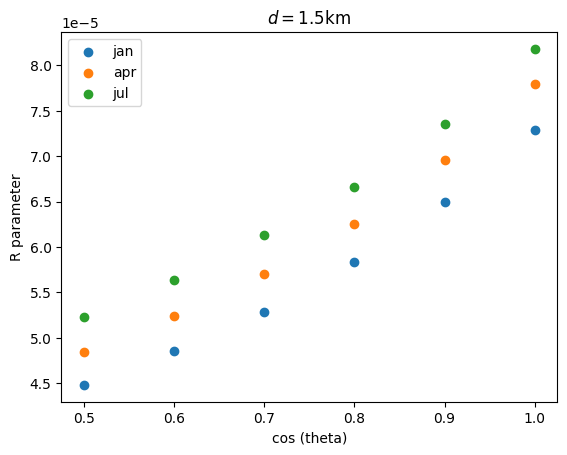

In [58]:
# plot default R

cos_thetas = np.linspace(0.5, 1.0, num=6)
thetas = np.degrees(np.arccos(cos_thetas))

plt.figure()
plt.tight_layout()

plt.scatter(cos_thetas,R_def_15_jan,label='jan')
plt.scatter(cos_thetas,R_def_15,label='apr')
plt.scatter(cos_thetas,R_def_15_jul,label='jul')
plt.xlabel('cos (theta)')
plt.title('$d=$1.5km')
plt.ylabel('R parameter')
plt.legend()
plt.savefig(plot_dir + 'R_default_costheta_1.5km.png')



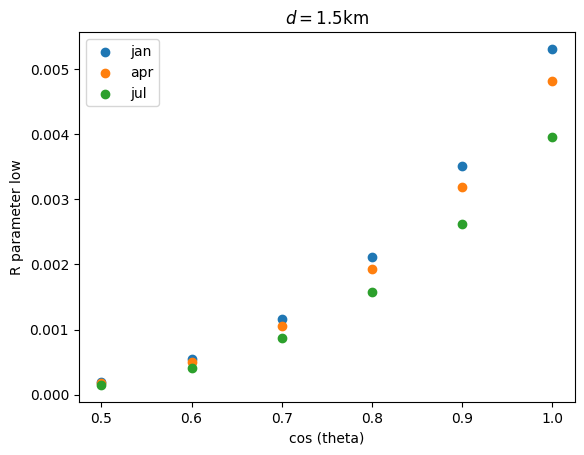

In [60]:
cos_thetas = np.linspace(0.5, 1.0, num=6)
thetas = np.degrees(np.arccos(cos_thetas))

plt.figure()
plt.tight_layout()
plt.scatter(cos_thetas,R_def_low_15_jan,label='jan')
plt.scatter(cos_thetas,R_def_low_15,label='apr')
plt.scatter(cos_thetas,R_def_low_15_jul,label='jul')
plt.xlabel('cos (theta)')
plt.title('$d=$1.5km')
plt.ylabel('R parameter low')
plt.legend()
plt.savefig(plot_dir + 'R_default_low_costheta_1.5km.png')


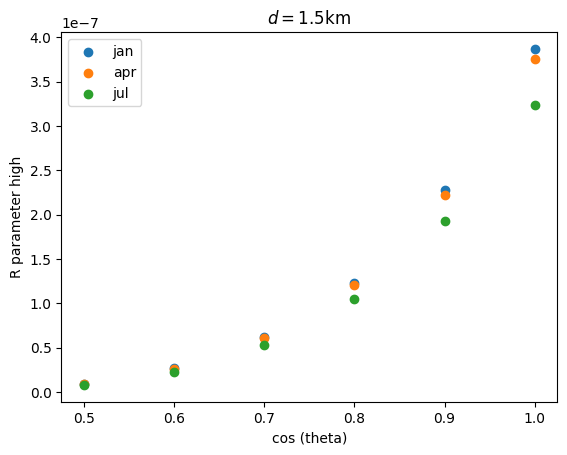

In [61]:
cos_thetas = np.linspace(0.5, 1.0, num=6)
thetas = np.degrees(np.arccos(cos_thetas))

plt.figure()
plt.tight_layout()
plt.scatter(cos_thetas,R_def_high_15_jan,label='jan')
plt.scatter(cos_thetas,R_def_high_15,label='apr')
plt.scatter(cos_thetas,R_def_high_15_jul,label='jul')
plt.xlabel('cos (theta)')
plt.title('$d=$1.5km')
plt.legend()
plt.ylabel('R parameter high')
plt.savefig(plot_dir + 'R_default_high_costheta_1.5km.png')


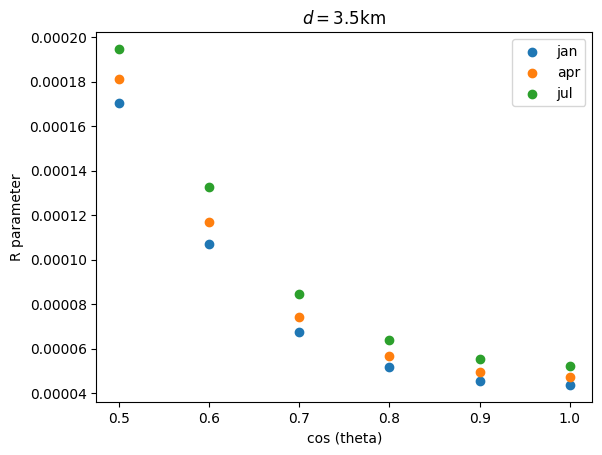

In [62]:
cos_thetas = np.linspace(0.5, 1.0, num=6)
thetas = np.degrees(np.arccos(cos_thetas))

plt.figure()
plt.tight_layout()
plt.scatter(cos_thetas,R_def_35_jan,label='jan')
plt.scatter(cos_thetas,R_def_35,label='apr')
plt.scatter(cos_thetas,R_def_35_jul,label='jul')
plt.xlabel('cos (theta)')
plt.ylabel('R parameter')
plt.title('$d=$3.5km')
plt.legend()
plt.savefig(plot_dir + 'R_default_costheta_3.5km.png')

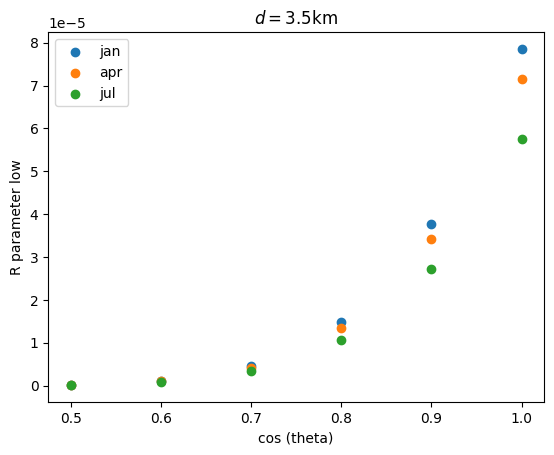

In [63]:
cos_thetas = np.linspace(0.5, 1.0, num=6)
thetas = np.degrees(np.arccos(cos_thetas))

plt.figure()
plt.tight_layout()
plt.scatter(cos_thetas,R_def_low_35_jan,label='jan')
plt.scatter(cos_thetas,R_def_low_35,label='apr')
plt.scatter(cos_thetas,R_def_low_35_jul,label='jul')
plt.xlabel('cos (theta)')
plt.title('$d=$3.5km')
plt.ylabel('R parameter low')
plt.legend()
plt.savefig(plot_dir + 'R_default_low_costheta_3.5km.png')

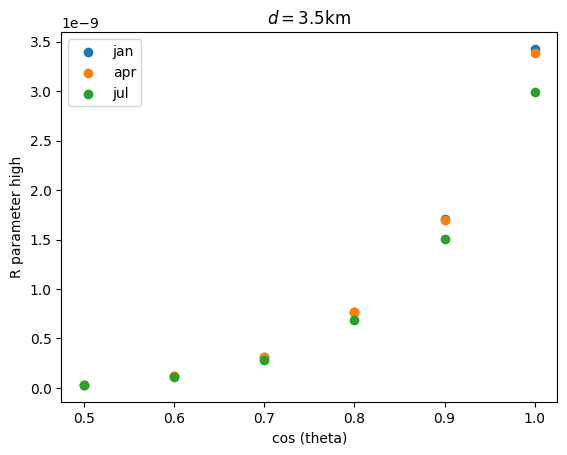

In [64]:
cos_thetas = np.linspace(0.5, 1.0, num=6)
thetas = np.degrees(np.arccos(cos_thetas))

plt.figure()
plt.tight_layout()
plt.scatter(cos_thetas,R_def_high_35_jan,label='jan')
plt.scatter(cos_thetas,R_def_high_35,label='apr')
plt.scatter(cos_thetas,R_def_high_35_jul,label='jul')
plt.xlabel('cos (theta)')
plt.title('$d=$3.5km')
plt.ylabel('R parameter high')
plt.legend()
plt.savefig(plot_dir + 'R_default_high_costheta_3.5km.png')

In [21]:
def dRdSig(R_array,cs_pion):

    slope = np.ndarray(shape=((len(e0_values)-2),6)) 

    for i in range(len(e0_values)-2):
        R1 = R_array[i]
        R2 = R_array[i+1]
        
        slope[i] = (R2-R1)/(0.01*cs_pion[i])

    return slope

In [22]:
dRdsig_15_cs101 = dRdSig(data_15_csp101,cs_pion_selected) # need to know energy bin here
dRdsig_35_cs101 = dRdSig(data_35_csp101,cs_pion_selected)

dRdsig_low_15_cs101 = dRdSig(R_low_15_csp101,cs_pion_selected) # need to know energy bin here
dRdsig_low_35_cs101 = dRdSig(R_low_35_csp101,cs_pion_selected)

dRdsig_high_15_cs101 = dRdSig(R_high_15_csp101,cs_pion_selected) # need to know energy bin here
dRdsig_high_35_cs101 = dRdSig(R_high_35_csp101,cs_pion_selected)

In [23]:
# Get six evenly spaced colors from the 'inferno' colormap
cmap = plt.get_cmap("inferno")
colors = [cmap(i) for i in np.linspace(0, 0.85, 7)]  # Max at 0.85 to avoid bright yellow

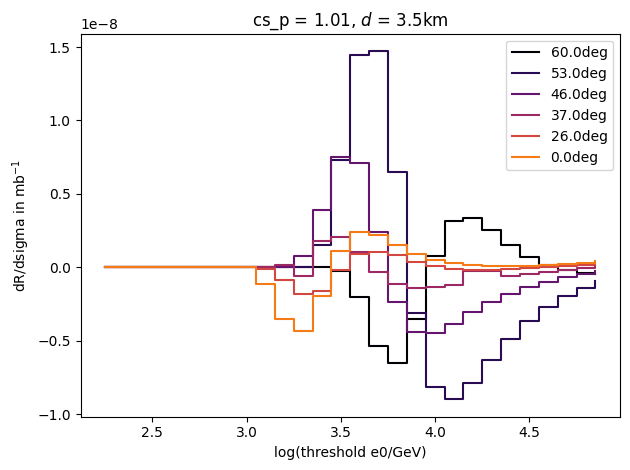

In [24]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_35_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dR/dsigma in mb$^{-1}$')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
if norm:
    plt.savefig(plot_dir + 'dRdsgima_csp1.01_depth3.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dRdsgima_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm.png')

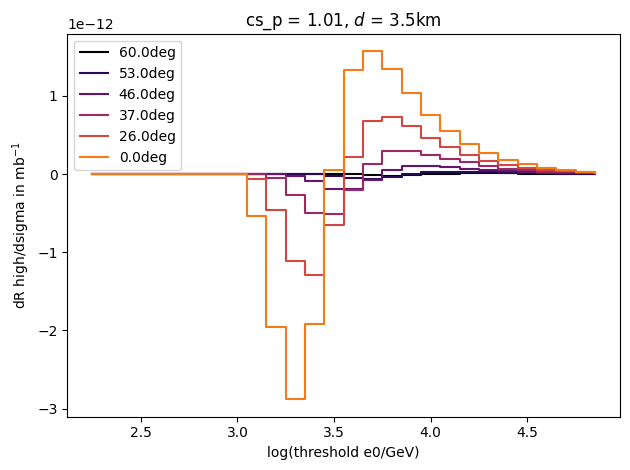

In [25]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_high_35_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dR high/dsigma in mb$^{-1}$')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
if norm:
    plt.savefig(plot_dir + 'dRhighdsgima_csp1.01_depth3.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dRhighdsgima_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm.png')

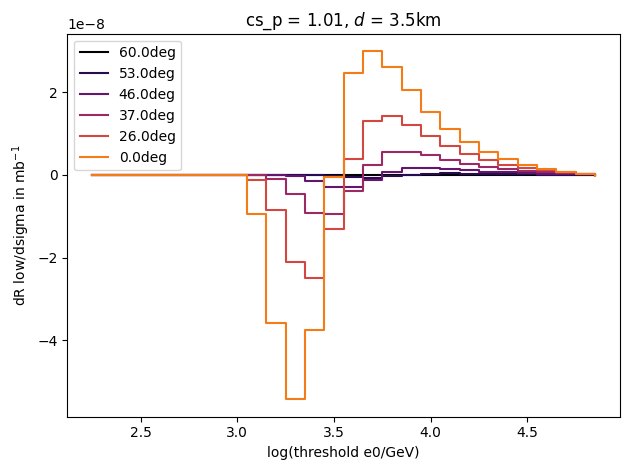

In [26]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_low_35_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dR low/dsigma in mb$^{-1}$')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
if norm:
    plt.savefig(plot_dir + 'dRlowdsgima_csp1.01_depth3.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dRlowdsgima_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm.png')

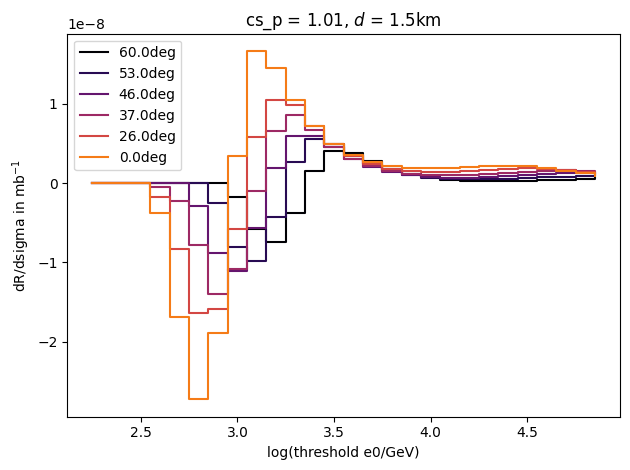

In [27]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_15_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 1.5km')
plt.ylabel('dR/dsigma in mb$^{-1}$')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.ylim(-0.05,0.05)
if norm:
    plt.savefig(plot_dir + 'dRdsgima_csp1.01_depth1.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dRdsgima_csp1.01_depth1.5_renormed_current_e0_1bin_nonorm.png')

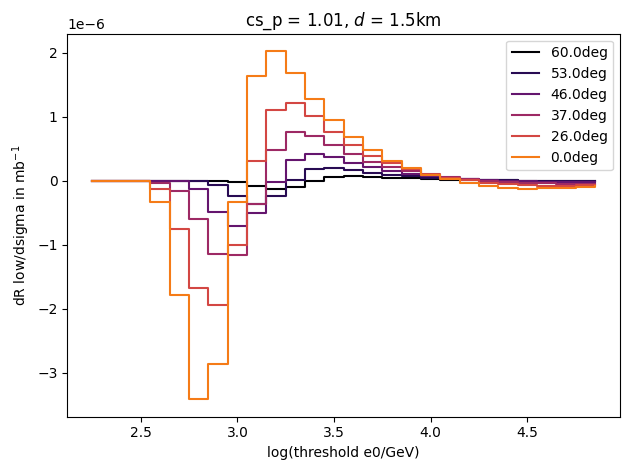

In [28]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_low_15_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 1.5km')
plt.ylabel('dR low/dsigma in mb$^{-1}$')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.ylim(-0.05,0.05)
if norm:
    plt.savefig(plot_dir + 'dRlowdsgima_csp1.01_depth1.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dRlowdsgima_csp1.01_depth1.5_renormed_current_e0_1bin_nonorm.png')

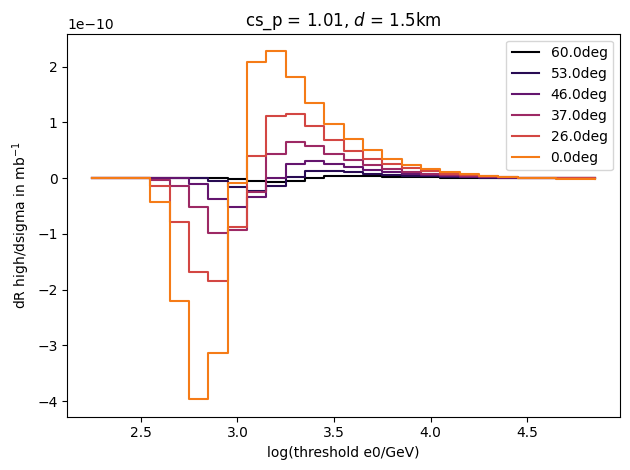

In [29]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_high_15_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 1.5km')
plt.ylabel('dR high/dsigma in mb$^{-1}$')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.ylim(-0.05,0.05)
if norm:
    plt.savefig(plot_dir + 'dRhighdsgima_csp1.01_depth1.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dRhighdsgima_csp1.01_depth1.5_renormed_current_e0_1bin_nonorm.png')

/tmp/ipykernel_126870/2888060439.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(e0_values[1:-1], dRdsig_35_cs101[:,j]**(-1), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])


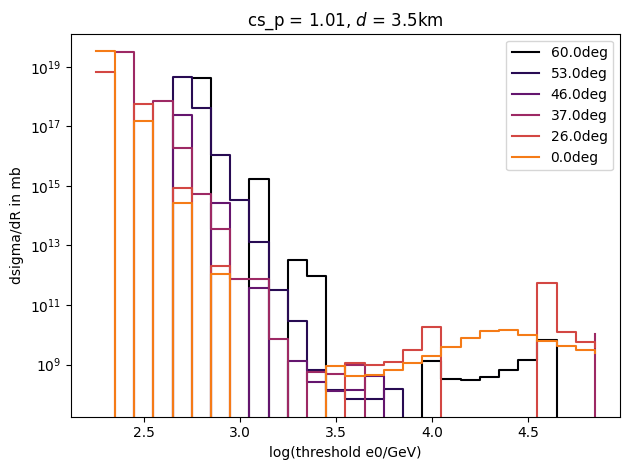

In [30]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_35_cs101[:,j]**(-1), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dsigma/dR in mb')
plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.ylim(-0.03,0.03)
if norm:
    plt.savefig(plot_dir + 'dsgimadR_csp1.01_depth3.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dsgimadR_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm.png')

/tmp/ipykernel_126870/2671595612.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(e0_values[1:-1], dRdsig_low_35_cs101[:,j]**(-1), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])


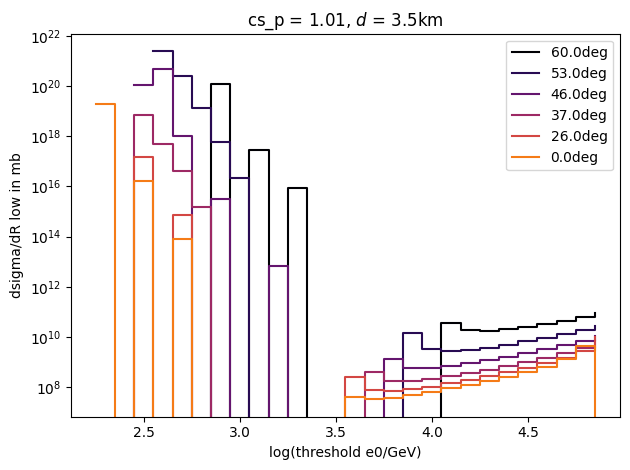

In [31]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_low_35_cs101[:,j]**(-1), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dsigma/dR low in mb')
plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.ylim(-0.03,0.03)
if norm:
    plt.savefig(plot_dir + 'dsgimadRlow_csp1.01_depth3.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dsgimadRlow_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm.png')

/tmp/ipykernel_126870/3046035972.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(e0_values[1:-1], dRdsig_high_35_cs101[:,j]**(-1), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])


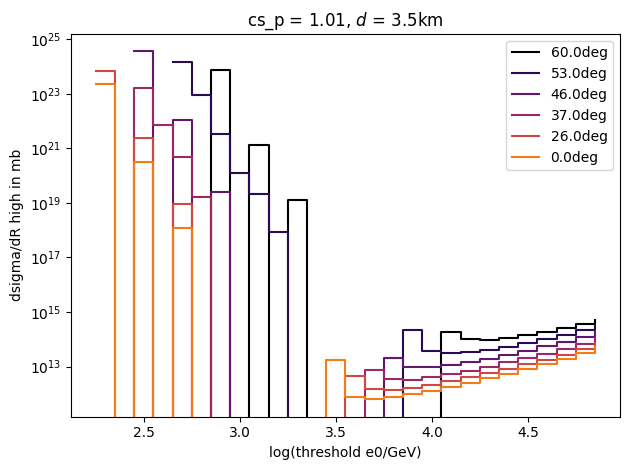

In [32]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_high_35_cs101[:,j]**(-1), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dsigma/dR high in mb')
plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.ylim(-0.03,0.03)
if norm:
    plt.savefig(plot_dir + 'dsgimadRhigh_csp1.01_depth3.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dsgimadRhigh_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm.png')

In [33]:
dRdsig_35_cs101[:,j]**(-1)

array([ 3.40358797e+19, -3.61761070e+18,  1.56877848e+17, -1.66061991e+16,
        2.73700046e+14, -3.71486754e+13,  1.07976951e+12, -1.10966451e+11,
       -8.84826611e+08, -2.81066042e+08, -2.30390252e+08, -5.14628093e+08,
        8.96103213e+08,  4.15474724e+08,  4.61922553e+08,  6.64962769e+08,
        1.08423232e+09,  1.96893551e+09,  3.89554800e+09,  8.04150193e+09,
        1.38791943e+10,  1.41948542e+10,  9.46666187e+09,  6.09256405e+09,
        4.24756149e+09,  3.16524673e+09,  2.50942931e+09])

how does R change with changing threshold - from here with high and low

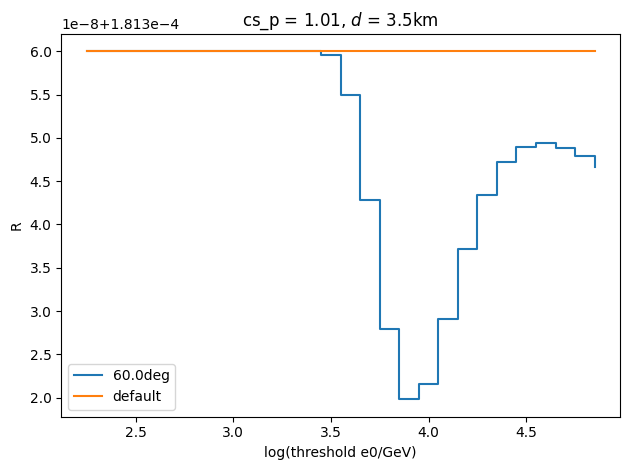

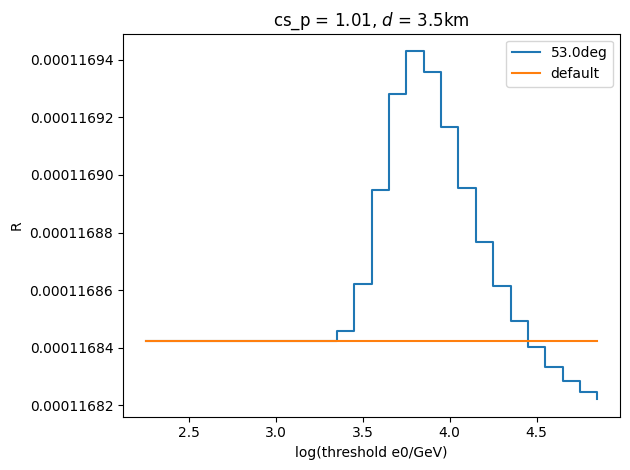

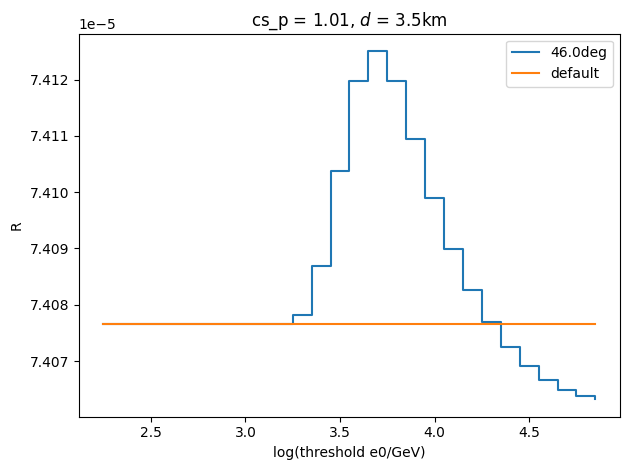

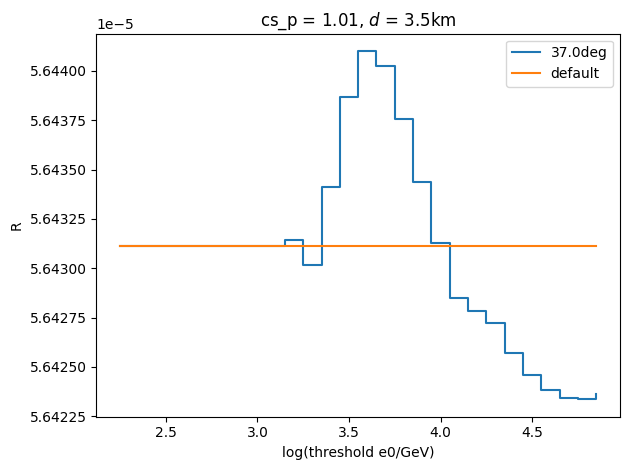

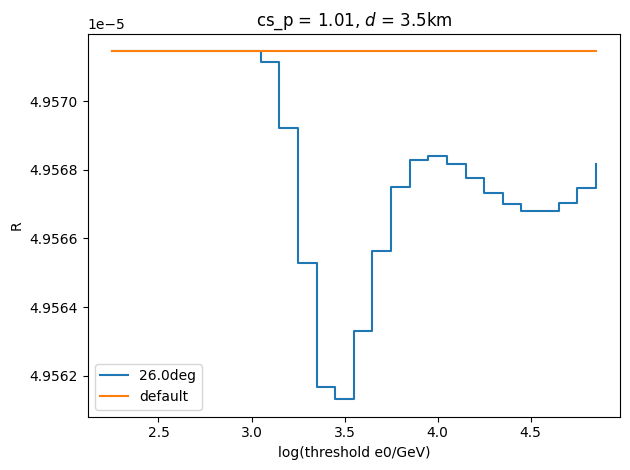

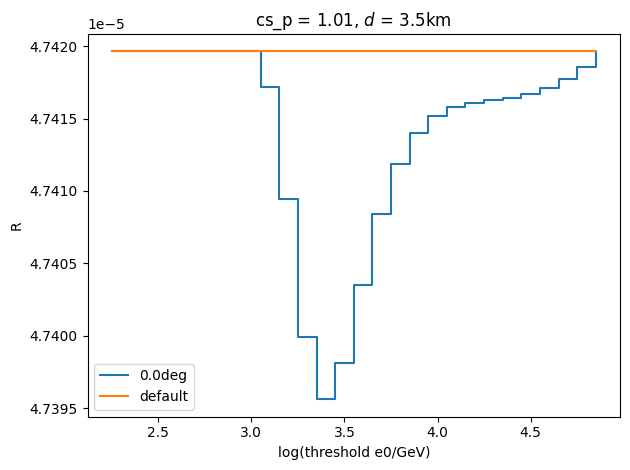

<Figure size 640x480 with 0 Axes>

In [34]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], data_35_csp101[1:-1,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')
    plt.plot(e0_values[1:-1],R_def_35[j]*np.ones(len(e0_values[1:-1])),label='default')

    # Add labels and title
    plt.xlabel('log(threshold e0/GeV)')
    plt.title('cs_p = 1.01, $d$ = 3.5km')
    plt.ylabel('R')
    #plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if norm:
        plt.savefig(plot_dir + 'E_R_csp1.01_depth3.5_renormed_current_e0_1bin_'+ str(np.round(angles[j],decimals=0)) +'deg.png')
    else:
        plt.savefig(plot_dir + 'E_R_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm_'+ str(np.round(angles[j],decimals=0)) +'deg.png')
    plt.show()
    plt.clf()

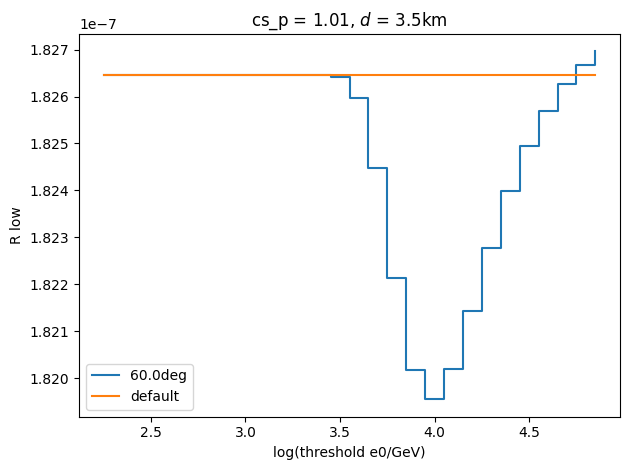

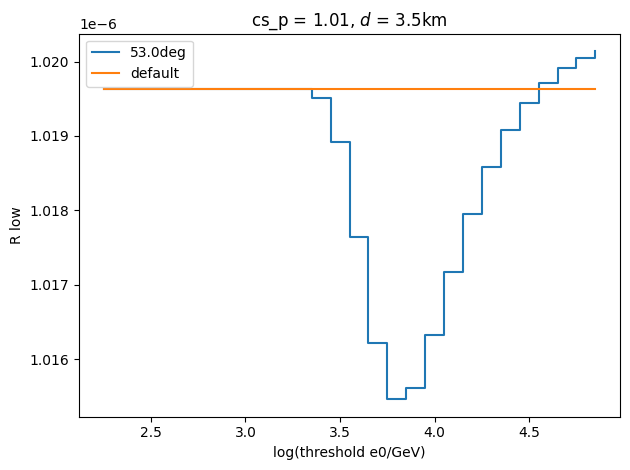

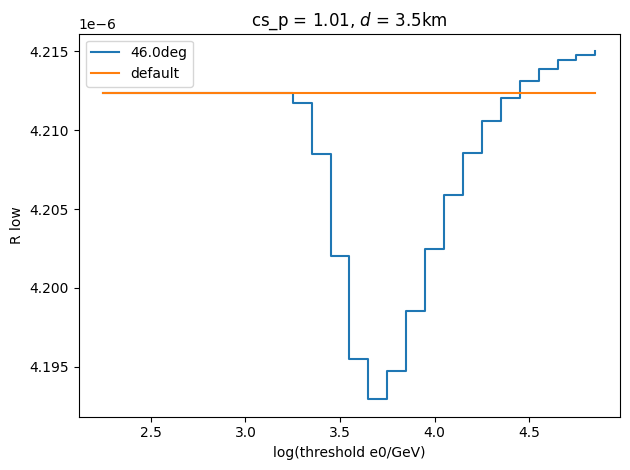

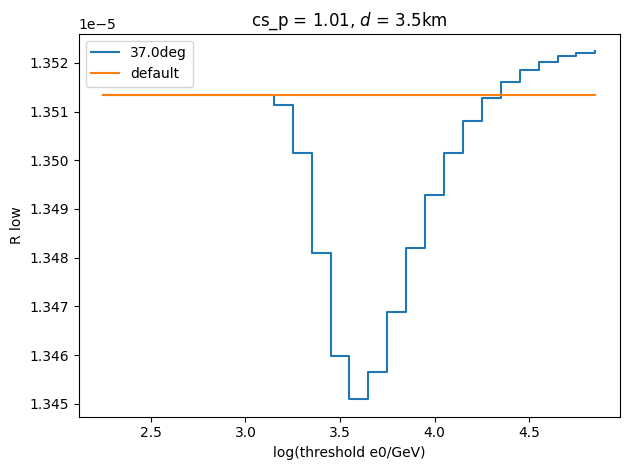

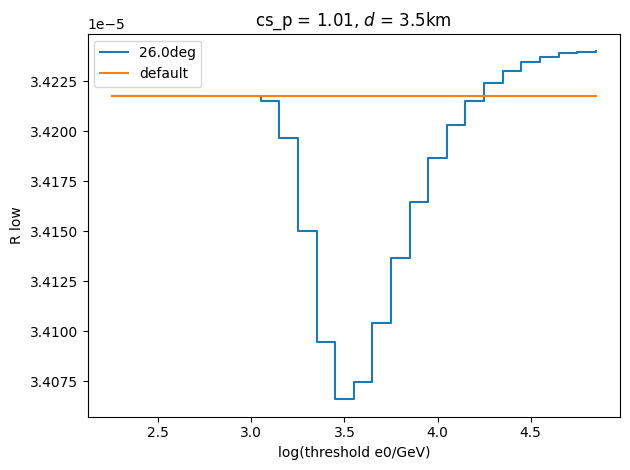

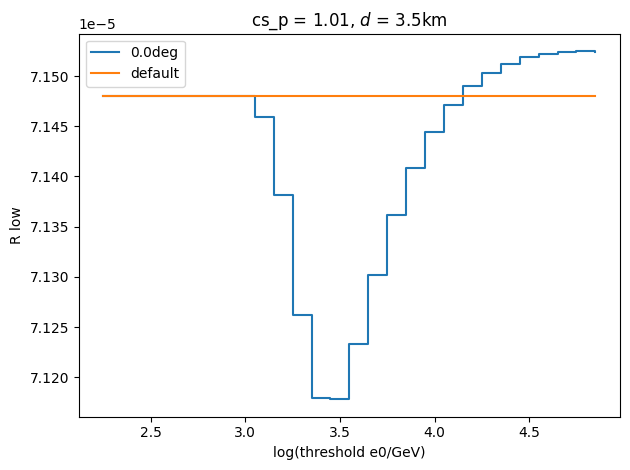

<Figure size 640x480 with 0 Axes>

In [35]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], R_low_35_csp101[1:-1,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')
    plt.plot(e0_values[1:-1],R_def_low_35[j]*np.ones(len(e0_values[1:-1])),label='default')

    # Add labels and title
    plt.xlabel('log(threshold e0/GeV)')
    plt.title('cs_p = 1.01, $d$ = 3.5km')
    plt.ylabel('R low')
    #plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if norm:
        plt.savefig(plot_dir + 'E_Rlow_csp1.01_depth3.5_renormed_current_e0_1bin_'+ str(np.round(angles[j],decimals=0)) +'deg.png')
    else:
        plt.savefig(plot_dir + 'E_Rlow_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm_'+ str(np.round(angles[j],decimals=0)) +'deg.png')
    plt.show()
    plt.clf()

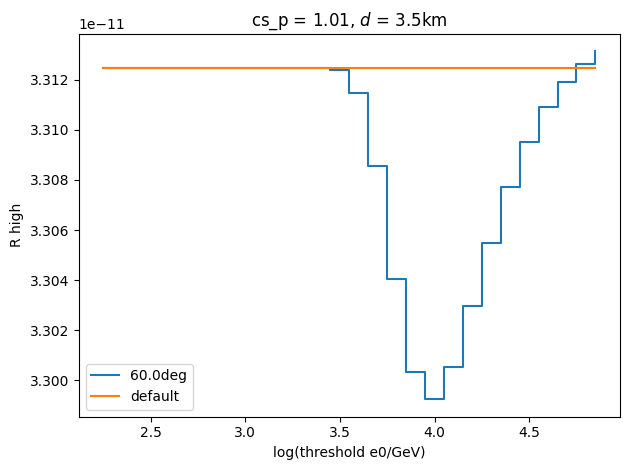

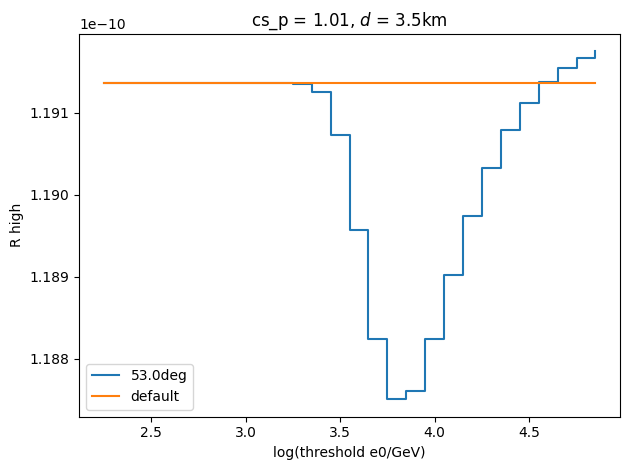

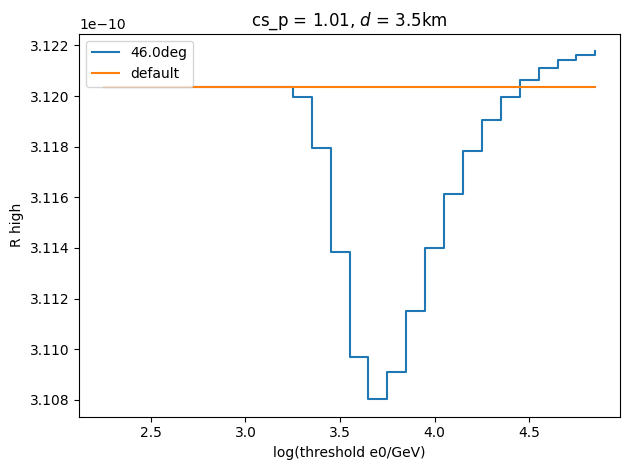

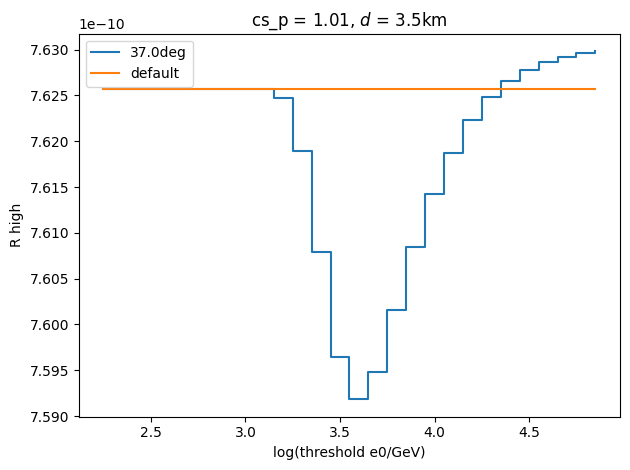

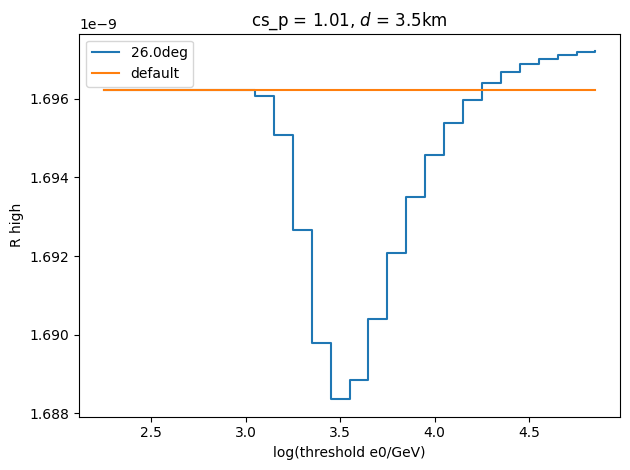

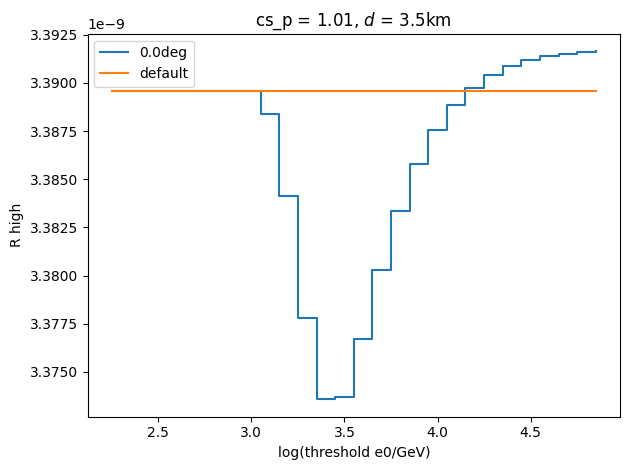

<Figure size 640x480 with 0 Axes>

In [36]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], R_high_35_csp101[1:-1,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')
    plt.plot(e0_values[1:-1],R_def_high_35[j]*np.ones(len(e0_values[1:-1])),label='default')

    # Add labels and title
    plt.xlabel('log(threshold e0/GeV)')
    plt.title('cs_p = 1.01, $d$ = 3.5km')
    plt.ylabel('R high')
    #plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if norm:
        plt.savefig(plot_dir + 'E_Rhigh_csp1.01_depth3.5_renormed_current_e0_1bin_'+ str(np.round(angles[j],decimals=0)) +'deg.png')
    else:
        plt.savefig(plot_dir + 'E_Rhigh_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm_'+ str(np.round(angles[j],decimals=0)) +'deg.png')
    plt.show()
    plt.clf()

In [37]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], data_15_csp101[1:-1,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')
    plt.plot(e0_values[1:-1],R_def_15[j]*np.ones(len(e0_values[1:-1])),label='default')

    # Add labels and title
    plt.xlabel('log(threshold e0/GeV)')
    plt.title('cs_p = 1.01, $d$ = 1.5km')
    plt.ylabel('dR/dsigma in mb$^{-1}$')
    #plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if norm:
        plt.savefig(plot_dir + 'E_R_csp1.01_depth1.5_renormed_current_e0_1bin_' + str(np.round(angles[j],decimals=0)) +'.png')
    else:
        plt.savefig(plot_dir + 'E_R_csp1.01_depth1.5_renormed_current_e0_1bin_nonorm' + str(np.round(angles[j],decimals=0)) +'.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [38]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], R_low_15_csp101[1:-1,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')
    plt.plot(e0_values[1:-1],R_def_low_15[j]*np.ones(len(e0_values[1:-1])),label='default')

    # Add labels and title
    plt.xlabel('log(threshold e0/GeV)')
    plt.title('cs_p = 1.01, $d$ = 1.5km')
    plt.ylabel('R low')
    #plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if norm:
        plt.savefig(plot_dir + 'E_Rlow_csp1.01_depth1.5_renormed_current_e0_1bin_' + str(np.round(angles[j],decimals=0)) +'.png')
    else:
        plt.savefig(plot_dir + 'E_Rlow_csp1.01_depth1.5_renormed_current_e0_1bin_nonorm' + str(np.round(angles[j],decimals=0)) +'.png')
    plt.clf()

for j in range(len(angles)):
    plt.plot(e0_values[1:-1], R_high_15_csp101[1:-1,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')
    plt.plot(e0_values[1:-1],R_def_high_15[j]*np.ones(len(e0_values[1:-1])),label='default')

    # Add labels and title
    plt.xlabel('log(threshold e0/GeV)')
    plt.title('cs_p = 1.01, $d$ = 1.5km')
    plt.ylabel('R high')
    #plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if norm:
        plt.savefig(plot_dir + 'E_Rhigh_csp1.01_depth1.5_renormed_current_e0_1bin_' + str(np.round(angles[j],decimals=0)) +'.png')
    else:
        plt.savefig(plot_dir + 'E_Rhigh_csp1.01_depth1.5_renormed_current_e0_1bin_nonorm' + str(np.round(angles[j],decimals=0)) +'.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [39]:
slant_depths = helper.slant_depths[2:-1:4]


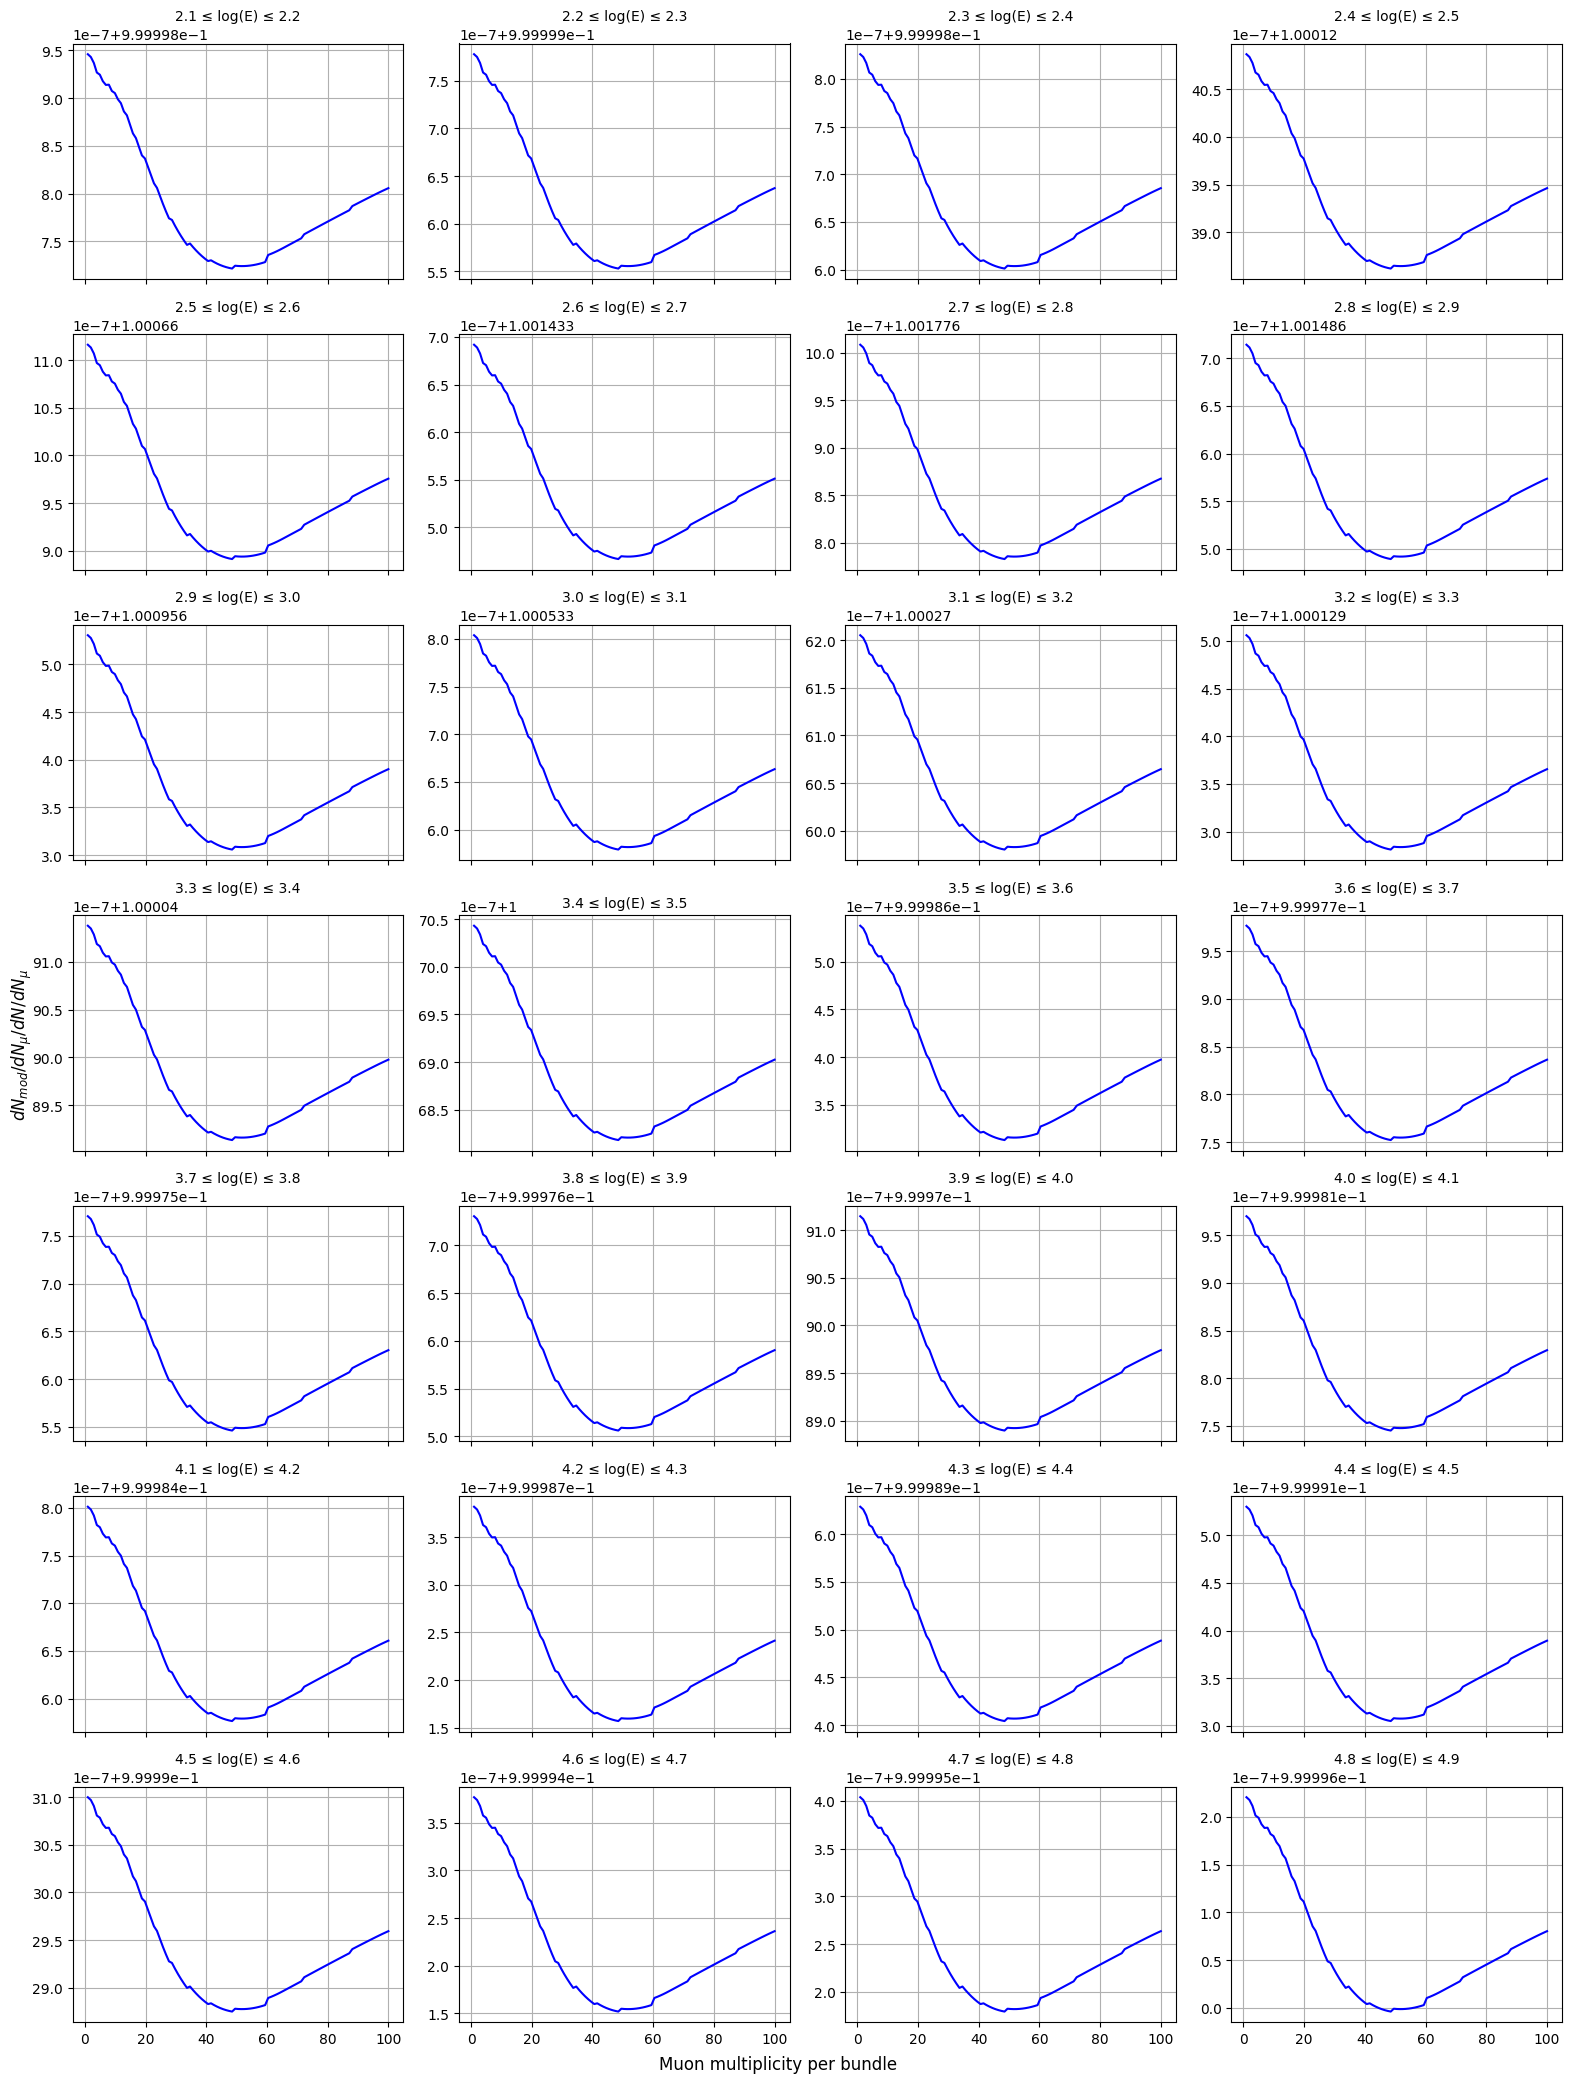

In [40]:
# Define bin edges and e0 values
bin_edges_cs = np.arange(2.1, 5.1 + 0.1, 0.1)
e0_values_list = [2.15, 2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 
                  3.15, 3.25, 3.35, 3.45, 3.55, 3.65, 3.75, 3.85, 3.95, 4.05, 
                  4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15]
X = 1.5
cs_k = 1.0

# Define subplot layout
n_plots = len(bin_edges_cs) - 3
ncols = 4
nrows = (n_plots + ncols - 1) // ncols  # Compute the number of rows needed

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Define a consistent color
plot_color = "blue"

# Loop through the bins and generate each subplot
for e in range(n_plots):
    ax = axes[e]
    
    # Compute the ratio
    ratio = (1e4 * helper.mult_dist(X, 0., pm.GlobalSplineFitBeta(), "yields_apr", 2212, 1.01, cs_k, 2.25, 2.45, norm=False) / 
             helper.rates(X, 0.0, "apr", 2212, 1.01, cs_k, e0_values_list[e], e0_values_list[e+1])) / \
            (1e4 * helper.mult_dist(X, 0., pm.GlobalSplineFitBeta(), "yields_apr", 2212, 1.0, cs_k, 2.05, norm=False) / 
             helper.rates(X, 0.0, "apr", 2212, 1.0, cs_k, 2.05, "None"))
    #print(ratio)
     
    # Compute a reasonable y-scale using powers of ten, focusing on deviations
    y_min = np.min(ratio)
    y_max = np.max(ratio)
    
    # Find the nearest powers of 10 for scaling
    ymin = 10 ** np.floor(np.log10(y_min))
    ymax = 10 ** np.ceil(np.log10(y_max))
    
    # Apply zoom-in logic to highlight deviations
    #ax.set_ylim([ymin * 0.8, ymax * 1.2])  # Slight expansion to avoid cutting edges
    
    # Plot the baseline line
    #ax.plot(helper.n_mu_vec, np.ones(len(helper.n_mu_vec)), color='black', linestyle="--")

    # Plot the ratio curve
    ax.plot(helper.n_mu_vec, ratio, label=f"{np.round(bin_edges_cs[e], 1)} ≤ log(E) ≤ {np.round(bin_edges_cs[e+1], 1)}", 
            color=plot_color)
    
    # Compute a reasonable y-scale using powers of ten
    #y_min = np.min(ratio)
    #y_max = np.max(ratio)
    
    # Find the nearest powers of 10
    #ymin = 10 ** np.floor(np.log10(y_min))
    #ymax = 10 ** np.ceil(np.log10(y_max))
    
    # Ensure y=1 is within the range
    #ymin = min(ymin, 1e-1)  # Prevent cutting off at unreasonable small values
    #ymax = max(ymax, 10)  # Prevent cutting off useful range
    
    #ax.set_ylim([ymin, ymax])

    # Set labels and title
    ax.set_title(f"{np.round(bin_edges_cs[e], 1)} ≤ log(E) ≤ {np.round(bin_edges_cs[e+1], 1)}", fontsize=10)
    ax.grid(True)

# Remove empty subplots if any
for i in range(n_plots, len(axes)):
    fig.delaxes(axes[i])

# Set common labels
fig.supxlabel("Muon multiplicity per bundle")
fig.supylabel(r"$dN_{mod}/dN_\mu / dN/dN_\mu$")
plt.tight_layout()
plt.savefig(plot_dir + 'bundlespectrum_ratio_cs_p1.01_energybin_test_1.5km.png')
plt.show()

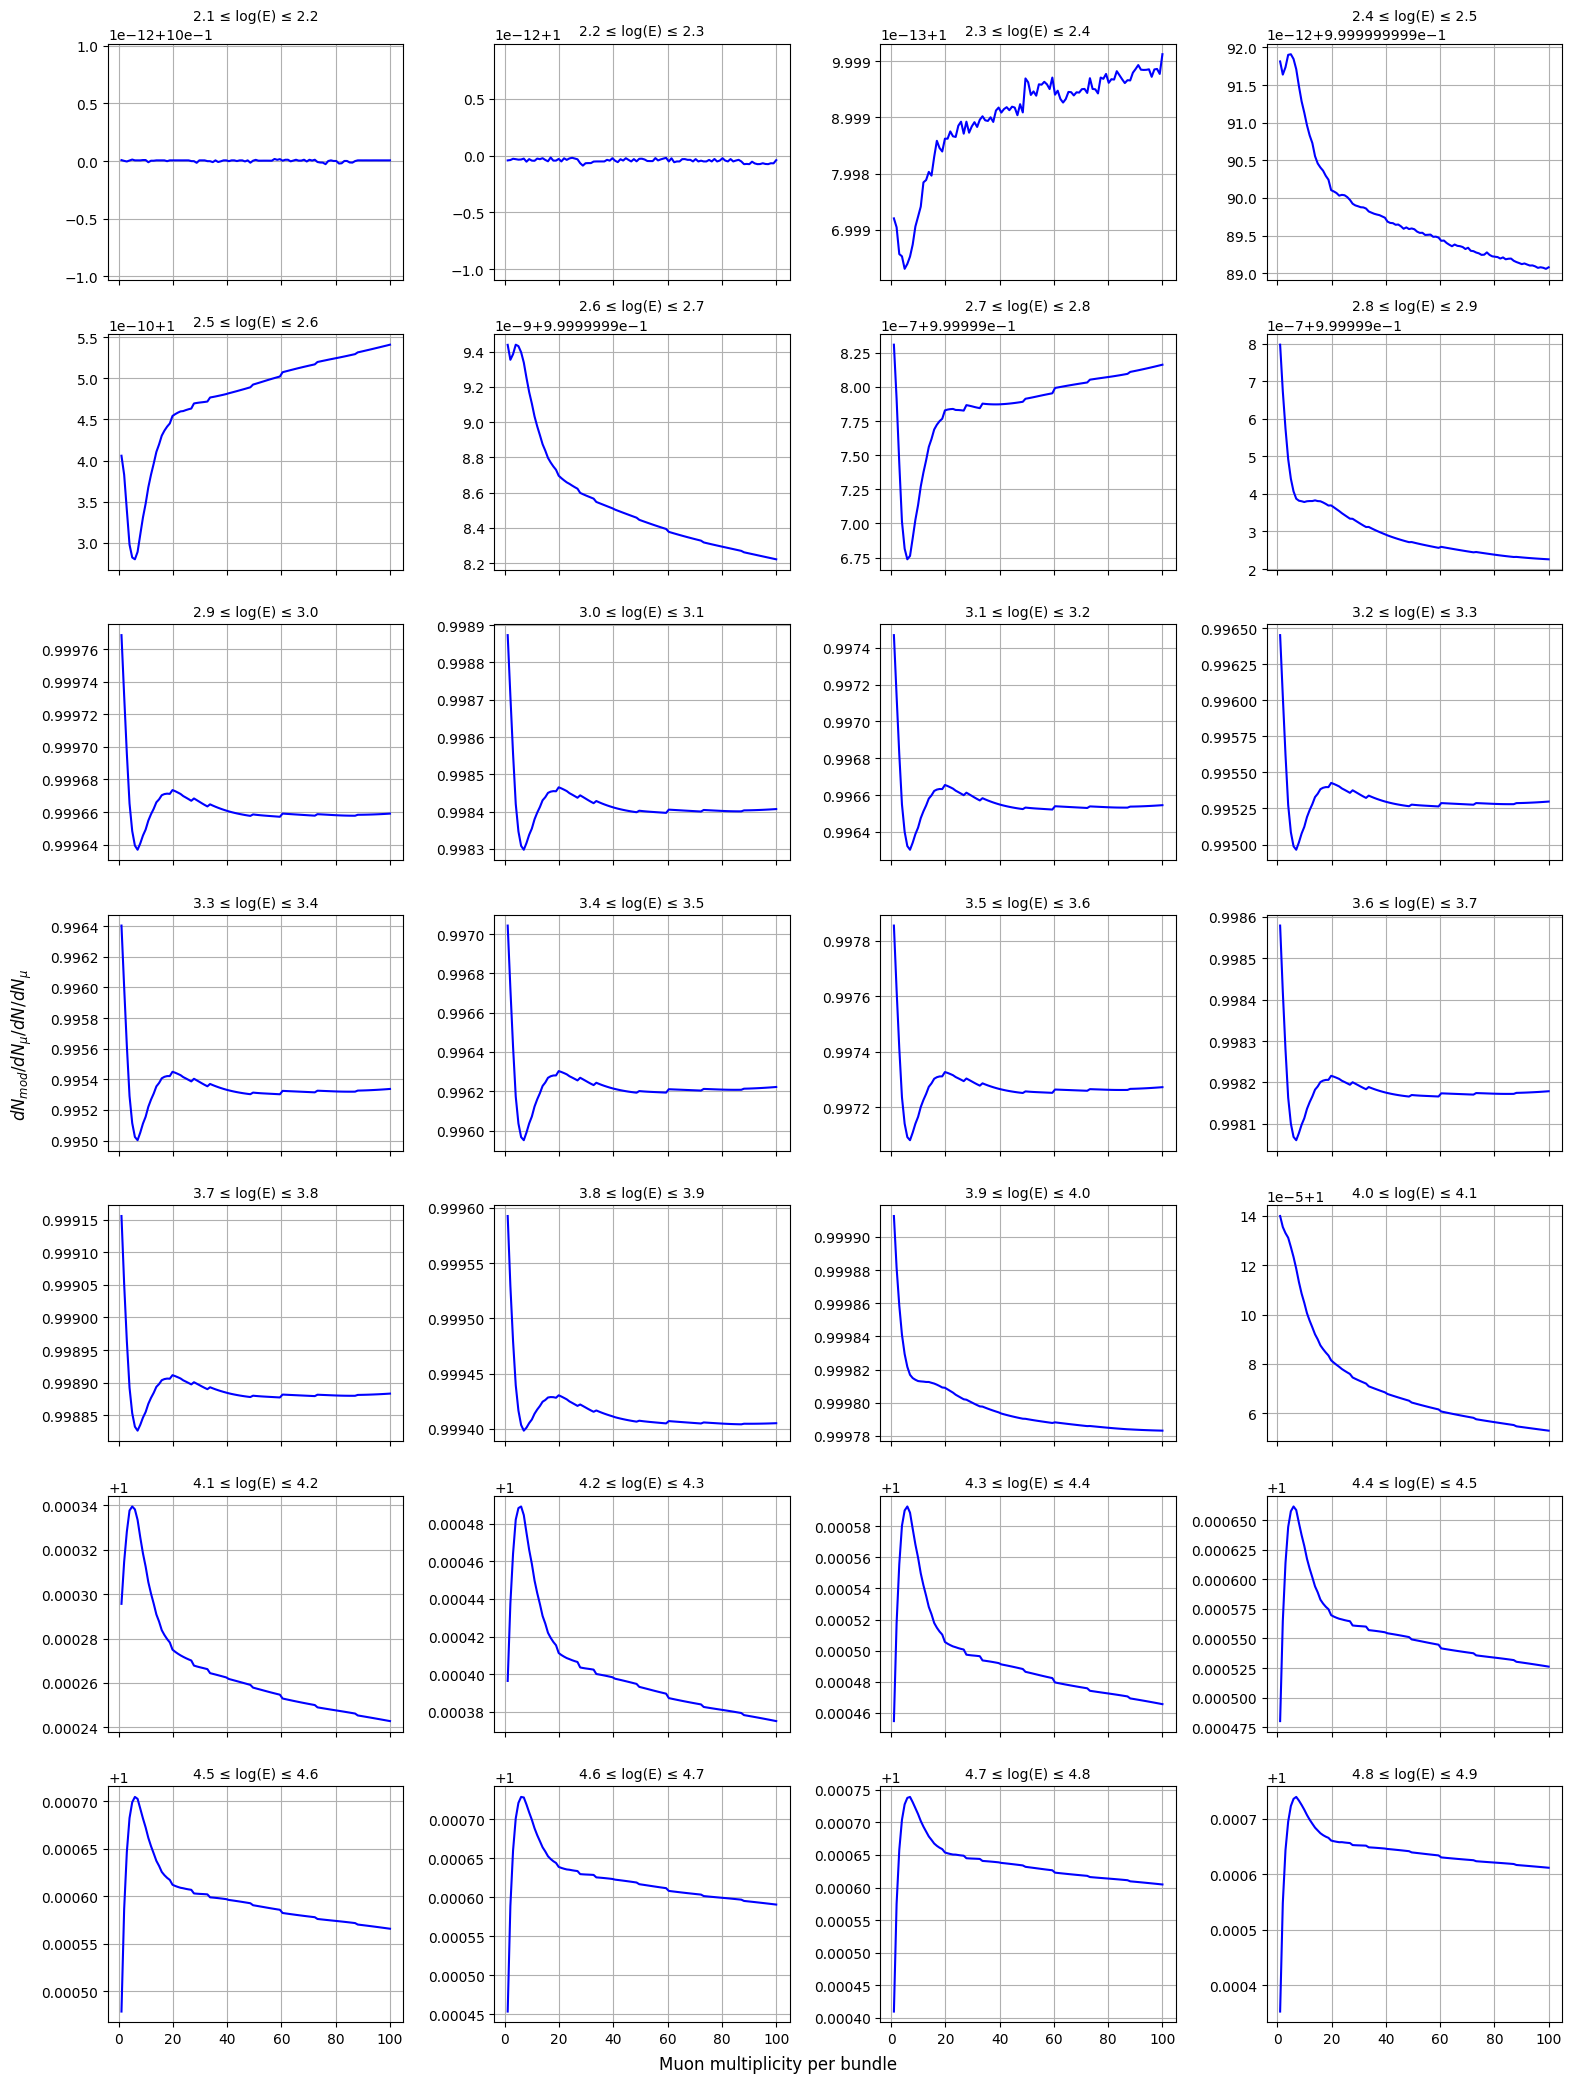

In [41]:
X = 3.5
n_plots = len(bin_edges_cs) - 3
ncols = 4
nrows = (n_plots + ncols - 1) // ncols  # Compute the number of rows needed

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Define a consistent color
plot_color = "blue"

# Loop through the bins and generate each subplot
for e in range(n_plots):
    ax = axes[e]
    
    # Compute the ratio
    ratio = (1e4 * helper.mult_dist(X, 0., pm.GlobalSplineFitBeta(), "yields_apr", 2212, 1.01, cs_k, e0_values_list[e], e0_values_list[e+1], norm=False) / 
             helper.rates(X, 0.0, "apr", 2212, 1.01, cs_k, e0_values_list[e], e0_values_list[e+1])) / \
            (1e4 * helper.mult_dist(X, 0., pm.GlobalSplineFitBeta(), "yields_apr", 2212, 1.0, cs_k, 2.05, norm=False) / 
             helper.rates(X, 0.0, "apr", 2212, 1.0, cs_k, 2.05, "None"))
    
     
    # Compute a reasonable y-scale using powers of ten, focusing on deviations
    y_min = np.min(ratio)
    y_max = np.max(ratio)
    
    # Find the nearest powers of 10 for scaling
    ymin = 10 ** np.floor(np.log10(y_min))
    ymax = 10 ** np.ceil(np.log10(y_max))
    
    # Apply zoom-in logic to highlight deviations
    #ax.set_ylim([ymin * 0.8, ymax * 1.2])  # Slight expansion to avoid cutting edges
    
    # Plot the baseline line
    #ax.plot(helper.n_mu_vec, np.ones(len(helper.n_mu_vec)), color='black', linestyle="--")

    # Plot the ratio curve
    ax.plot(helper.n_mu_vec, ratio, label=f"{np.round(bin_edges_cs[e], 1)} ≤ log(E) ≤ {np.round(bin_edges_cs[e+1], 1)}", 
            color=plot_color)
    
    # Compute a reasonable y-scale using powers of ten
    #y_min = np.min(ratio)
    #y_max = np.max(ratio)
    
    # Find the nearest powers of 10
    #ymin = 10 ** np.floor(np.log10(y_min))
    #ymax = 10 ** np.ceil(np.log10(y_max))
    
    # Ensure y=1 is within the range
    #ymin = min(ymin, 1e-1)  # Prevent cutting off at unreasonable small values
    #ymax = max(ymax, 10)  # Prevent cutting off useful range
    
    #ax.set_ylim([ymin, ymax])

    # Set labels and title
    ax.set_title(f"{np.round(bin_edges_cs[e], 1)} ≤ log(E) ≤ {np.round(bin_edges_cs[e+1], 1)}", fontsize=10)
    ax.grid(True)

# Remove empty subplots if any
for i in range(n_plots, len(axes)):
    fig.delaxes(axes[i])

# Set common labels
fig.supxlabel("Muon multiplicity per bundle")
fig.supylabel(r"$dN_{mod}/dN_\mu / dN/dN_\mu$")
plt.tight_layout()
plt.savefig(plot_dir + 'bundlespectrum_ratio_cs_p1.01_energybin_test_3.5km.png')
plt.show()

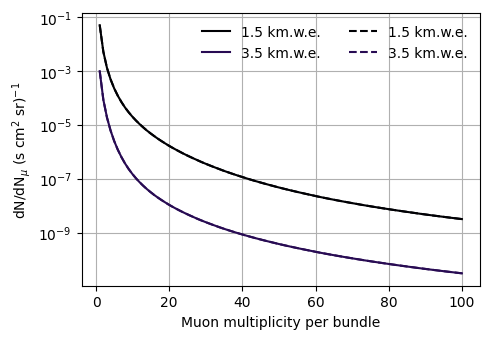

In [42]:
# understand figures
import mceq_underground_helpers_oneregion as mhh
cs_k = 1.0



plt.figure(figsize=(5.0, 3.5))
lines=[]
angle = 0.0
for i, X in enumerate(slant_depths[0:2]):  
    plt.semilogy(
        mh.n_mu_vec,
        1e4*mhh.mult_dist(X,
                        0.,
                        pm.GlobalSplineFitBeta(),"yields_apr",
                        2212,
                        1.01, cs_k, 2.25,2.45,
                        norm=False#))[0]
                    ) / mhh.rates(X, angle, "apr", 2212, 1.01, cs_k, 2.25,2.45),
        c=colors[i],
        label=r"{0:3.1f} km.w.e.".format(X),
    )[0]

for i, X in enumerate(slant_depths[0:2]):  
    plt.semilogy(
        mh.n_mu_vec,
        1e4*mhh.mult_dist(X,
                        0.,
                        pm.GlobalSplineFitBeta(),"yields_apr",
                        2212,
                        1.0, cs_k, 2.05,
                        norm=False#))[0]
                    ) / mhh.rates(X, angle, "apr", 2212, 1.0, cs_k, 2.05,"inf"),
        c=colors[i], ls='--',
        label=r"{0:3.1f} km.w.e.".format(X),
    )[0]
    
plt.xlabel("Muon multiplicity per bundle")
plt.ylabel(r"dN/dN$_\mu$ (s cm$^2$ sr)$^{-1}$")
lines.append(mlines.Line2D([], [], color='k', linestyle="--", label="jul"))
plt.legend(handles=lines, frameon=False, loc="lower left")
plt.legend(frameon=False, ncol=2)
# plt.ylim(1e-11, 8e-5)
# plt.xlim(4,100)

plt.grid()
plt.tight_layout()

plt.savefig(plot_dir + 'multiperbundle_energybintest_cs_p1.01_depth1.5km.png')

<>:31: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_126870/3400271839.py:31: SyntaxWarning: invalid escape sequence '\l'
  plt.title("$3.3 \leq \log(E) \leq 3.4$")


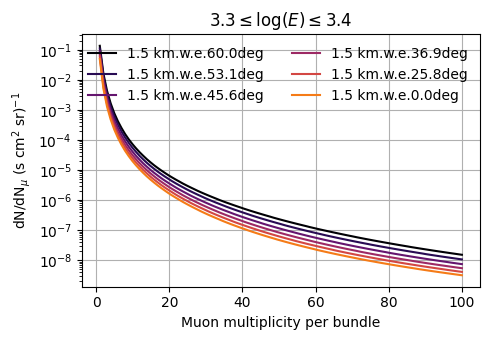

In [43]:
# plto for differnt angles

cs_k = 1.0


plt.figure(figsize=(5.0, 3.5))
lines=[]
for j in range(len(angles)):
    angle = angles[j]
    X  = slant_depths[0]  
    plt.semilogy(
        mh.n_mu_vec,
        1e4*mhh.mult_dist(X,
                        angles[j],
                        pm.GlobalSplineFitBeta(),"yields_apr",
                        2212,
                        1.01, cs_k, 2.25,2.45,
                        norm=False#))[0]
                    ) / mhh.rates(X, angle, "apr", 2212, 1.01, cs_k, 3.25,3.45),
        c=colors[j],
        label=r"{0:3.1f} km.w.e.".format(X) + str(np.round(angles[j],decimals=1)) + "deg",
    )[0]

    
    
plt.xlabel("Muon multiplicity per bundle")
plt.ylabel(r"dN/dN$_\mu$ (s cm$^2$ sr)$^{-1}$")
lines.append(mlines.Line2D([], [], color='k', linestyle="--", label="jul"))
plt.legend(handles=lines, frameon=False, loc="lower left")
plt.legend(frameon=False, ncol=2)
plt.title("$3.3 \leq \log(E) \leq 3.4$")
# plt.ylim(1e-11, 8e-5)
# plt.xlim(4,100)

plt.grid()
plt.tight_layout()

plt.savefig(plot_dir + 'multiperbundle_energybintest_cs_p1.01_depth1.5km.png')

<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_126870/129820205.py:29: SyntaxWarning: invalid escape sequence '\l'
  plt.title("$3.3 \leq \log(E) \leq 3.4$")


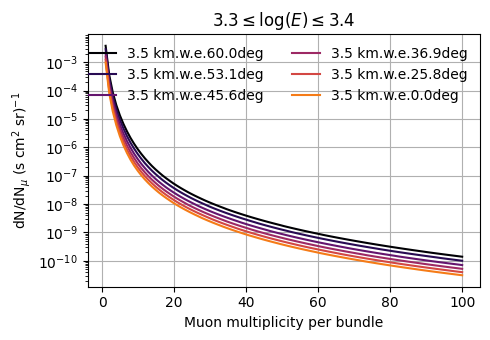

In [55]:
cs_k = 1.0


plt.figure(figsize=(5.0, 3.5))
lines=[]
for j in range(len(angles)):
    angle = angles[j]
    X  = slant_depths[1]  
    plt.semilogy(
        mh.n_mu_vec,
        1e4*mhh.mult_dist(X,
                        angles[j],
                        pm.GlobalSplineFitBeta(),"yields_apr",
                        2212,
                        1.01, cs_k, 2.25,2.45,
                        norm=False#))[0]
                    ) / mhh.rates(X, angle, "apr", 2212, 1.01, cs_k, 3.25,3.45),
        c=colors[j],
        label=r"{0:3.1f} km.w.e.".format(X) + str(np.round(angles[j],decimals=1)) + "deg",
    )[0]

    
    
plt.xlabel("Muon multiplicity per bundle")
plt.ylabel(r"dN/dN$_\mu$ (s cm$^2$ sr)$^{-1}$")
lines.append(mlines.Line2D([], [], color='k', linestyle="--", label="jul"))
plt.legend(handles=lines, frameon=False, loc="lower left")
plt.legend(frameon=False, ncol=2)
plt.title("$3.3 \leq \log(E) \leq 3.4$")
# plt.ylim(1e-11, 8e-5)
# plt.xlim(4,100)

plt.grid()
plt.tight_layout()

plt.savefig(plot_dir + 'multiperbundle_energybintest_cs_p1.01_depth3.5km.png')

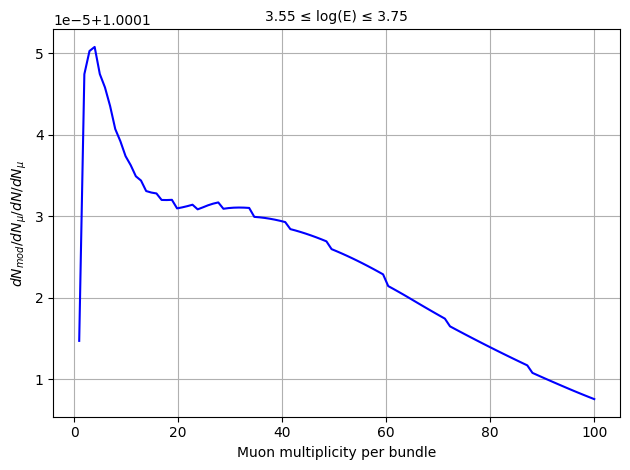

In [44]:
# ratio for selected bins

X = 1.5
cs_k = 1.0

plt.figure()

# Define a consistent color
plot_color = "blue"

# Compute the ratio
ratio = (1e4 * helper.mult_dist(X, 0., pm.GlobalSplineFitBeta(), "yields_apr", 2212, 1.01, cs_k, 3.55, 3.75, norm=False) / 
            helper.rates(X, 0.0, "apr", 2212, 1.01, cs_k, 3.55,3.75)) / \
        (1e4 * helper.mult_dist(X, 0., pm.GlobalSplineFitBeta(), "yields_apr", 2212, 1.0, cs_k, 2.05, norm=False) / 
            helper.rates(X, 0.0, "apr", 2212, 1.0, cs_k, 2.05, "None"))

# Compute a reasonable y-scale using powers of ten, focusing on deviations
y_min = np.min(ratio)
y_max = np.max(ratio)

# Find the nearest powers of 10 for scaling
ymin = 10 ** np.floor(np.log10(y_min))
ymax = 10 ** np.ceil(np.log10(y_max))

# Apply zoom-in logic to highlight deviations
#ax.set_ylim([ymin * 0.8, ymax * 1.2])  # Slight expansion to avoid cutting edges

# Plot the baseline line
#ax.plot(helper.n_mu_vec, np.ones(len(helper.n_mu_vec)), color='black', linestyle="--")

# Plot the ratio curve
plt.plot(helper.n_mu_vec, ratio, label= "3.55 ≤ log(E) ≤ 3.75", 
        color=plot_color)

# Compute a reasonable y-scale using powers of ten
#y_min = np.min(ratio)
#y_max = np.max(ratio)

# Find the nearest powers of 10
#ymin = 10 ** np.floor(np.log10(y_min))
#ymax = 10 ** np.ceil(np.log10(y_max))

# Ensure y=1 is within the range
#ymin = min(ymin, 1e-1)  # Prevent cutting off at unreasonable small values
#ymax = max(ymax, 10)  # Prevent cutting off useful range

#ax.set_ylim([ymin, ymax])

# Set labels and title
plt.title("3.55 ≤ log(E) ≤ 3.75", fontsize=10)
plt.grid(True)




# Set common labels
plt.xlabel("Muon multiplicity per bundle")
plt.ylabel(r"$dN_{mod}/dN_\mu / dN/dN_\mu$")
plt.tight_layout()
plt.savefig(plot_dir + 'bundlespectrum_ratio_cs_p1.01_energybin_test_1.5km_logE_3.55-3.75.png')
plt.show()


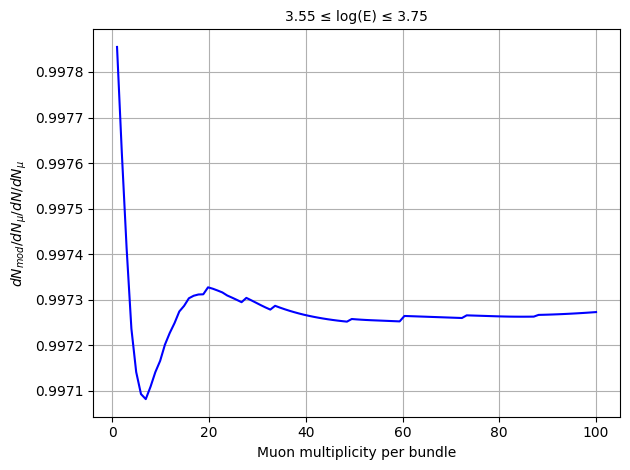

In [45]:
# ratio for selected bins

X = 3.5
cs_k = 1.0

plt.figure()

# Define a consistent color
plot_color = "blue"

# Compute the ratio
ratio = (1e4 * helper.mult_dist(X, 0., pm.GlobalSplineFitBeta(), "yields_apr", 2212, 1.01, cs_k, 3.55, 3.75, norm=False) / 
            helper.rates(X, 0.0, "apr", 2212, 1.01, cs_k, 3.55,3.75)) / \
        (1e4 * helper.mult_dist(X, 0., pm.GlobalSplineFitBeta(), "yields_apr", 2212, 1.0, cs_k, 2.05, norm=False) / 
            helper.rates(X, 0.0, "apr", 2212, 1.0, cs_k, 2.05, "None"))

# Compute a reasonable y-scale using powers of ten, focusing on deviations
y_min = np.min(ratio)
y_max = np.max(ratio)

# Find the nearest powers of 10 for scaling
ymin = 10 ** np.floor(np.log10(y_min))
ymax = 10 ** np.ceil(np.log10(y_max))

# Apply zoom-in logic to highlight deviations
#ax.set_ylim([ymin * 0.8, ymax * 1.2])  # Slight expansion to avoid cutting edges

# Plot the baseline line
#ax.plot(helper.n_mu_vec, np.ones(len(helper.n_mu_vec)), color='black', linestyle="--")

# Plot the ratio curve
plt.plot(helper.n_mu_vec, ratio, label= "3.55 ≤ log(E) ≤ 3.75", 
        color=plot_color)

# Compute a reasonable y-scale using powers of ten
#y_min = np.min(ratio)
#y_max = np.max(ratio)

# Find the nearest powers of 10
#ymin = 10 ** np.floor(np.log10(y_min))
#ymax = 10 ** np.ceil(np.log10(y_max))

# Ensure y=1 is within the range
#ymin = min(ymin, 1e-1)  # Prevent cutting off at unreasonable small values
#ymax = max(ymax, 10)  # Prevent cutting off useful range

#ax.set_ylim([ymin, ymax])

# Set labels and title
plt.title("3.55 ≤ log(E) ≤ 3.75", fontsize=10)
plt.grid(True)




# Set common labels
plt.xlabel("Muon multiplicity per bundle")
plt.ylabel(r"$dN_{mod}/dN_\mu / dN/dN_\mu$")
plt.tight_layout()
plt.savefig(plot_dir + 'bundlespectrum_ratio_cs_p1.01_energybin_test_3.5km_logE_3.55-3.75.png')
plt.show()


<>:25: SyntaxWarning: invalid escape sequence '\T'
<>:25: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_126870/3705376111.py:25: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('cos($\Theta$)')


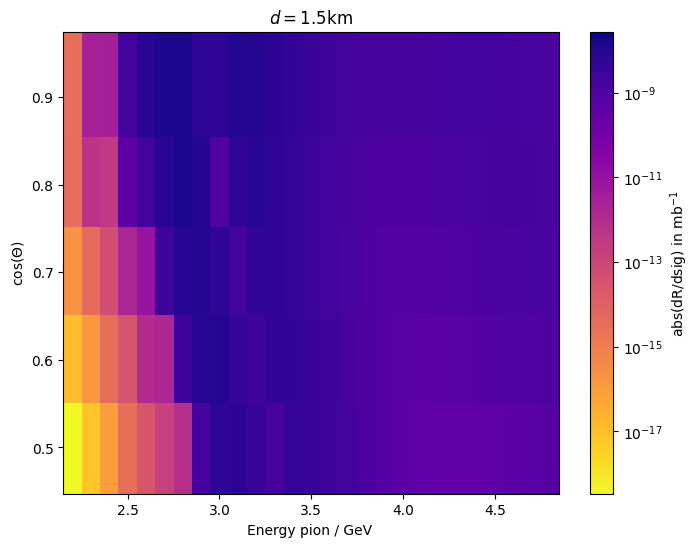

In [46]:
from matplotlib.colors import LogNorm
z = np.abs(dRdsig_15_cs101)
z_min = np.min(z)
z_max = np.max(z)


# Calculate the first and last bin edges
angle_edges = np.zeros(len(angles) + 1)
angle_edges[0] = angles[0] - (angles[1] - angles[0]) / 2
angle_edges[-1] = angles[-1] + (angles[-1] - angles[-2]) / 2

# Calculate edges for the interior bins
for i in range(1, len(angles)):
    angle_edges[i] = (angles[i-1] + angles[i]) / 2

plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_values[:-1],  np.cos(np.deg2rad(angle_edges)), z.T, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dR/dsig) in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('cos($\Theta$)')
plt.title('$d=$1.5km')


# Display the plot
plt.savefig(plot_dir + '2D_dRdsig_angle_energy_ebintest_d1.5km.png')
plt.show()


<>:24: SyntaxWarning: invalid escape sequence '\T'
<>:24: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_126870/4086864682.py:24: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('cos($\Theta$)')


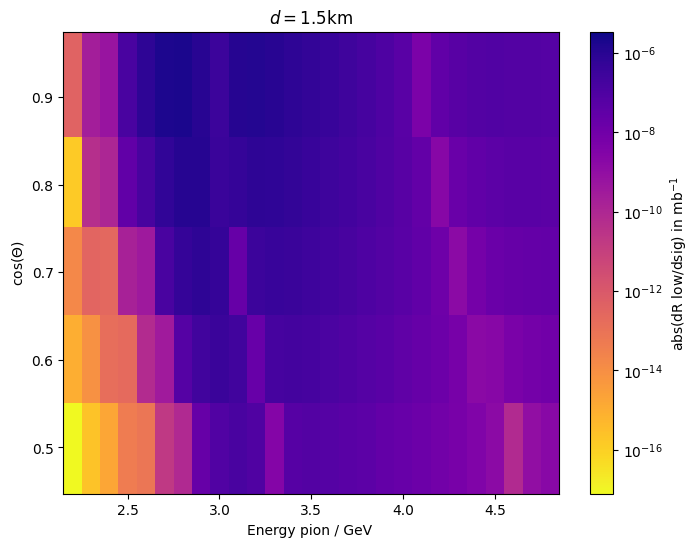

In [47]:
z = np.abs(dRdsig_low_15_cs101)
z_min = np.min(z)
z_max = np.max(z)


# Calculate the first and last bin edges
angle_edges = np.zeros(len(angles) + 1)
angle_edges[0] = angles[0] - (angles[1] - angles[0]) / 2
angle_edges[-1] = angles[-1] + (angles[-1] - angles[-2]) / 2

# Calculate edges for the interior bins
for i in range(1, len(angles)):
    angle_edges[i] = (angles[i-1] + angles[i]) / 2

plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_values[:-1],  np.cos(np.deg2rad(angle_edges)), z.T, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dR low/dsig) in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('cos($\Theta$)')
plt.title('$d=$1.5km')


# Display the plot
plt.savefig(plot_dir + '2D_dRlowdsig_angle_energy_ebintest_csp1.01_d1.5km.png')
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\T'
<>:24: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_126870/1099567410.py:24: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('cos($\Theta$)')


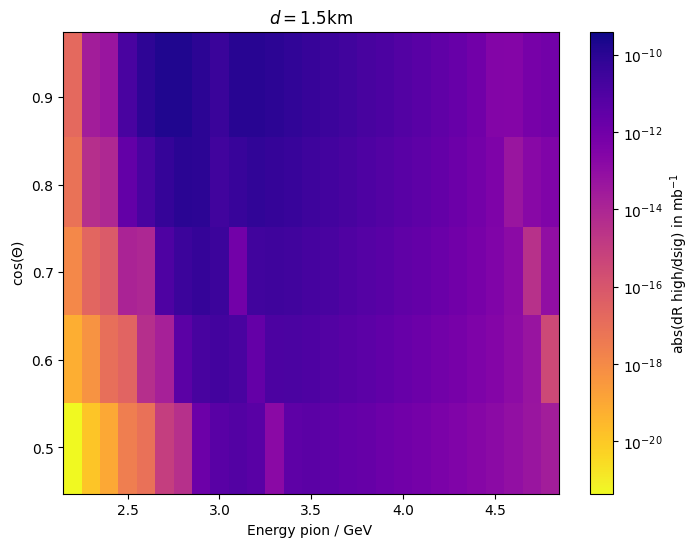

In [48]:
z = np.abs(dRdsig_high_15_cs101)
z_min = np.min(z)
z_max = np.max(z)


# Calculate the first and last bin edges
angle_edges = np.zeros(len(angles) + 1)
angle_edges[0] = angles[0] - (angles[1] - angles[0]) / 2
angle_edges[-1] = angles[-1] + (angles[-1] - angles[-2]) / 2

# Calculate edges for the interior bins
for i in range(1, len(angles)):
    angle_edges[i] = (angles[i-1] + angles[i]) / 2

plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_values[:-1],  np.cos(np.deg2rad(angle_edges)), z.T, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dR high/dsig) in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('cos($\Theta$)')
plt.title('$d=$1.5km')


# Display the plot
plt.savefig(plot_dir + '2D_dRhighdsig_angle_energy_ebintest_csp1.01_d1.5km.png')
plt.show()

<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_126870/2865729501.py:11: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('cos($\Theta$)')


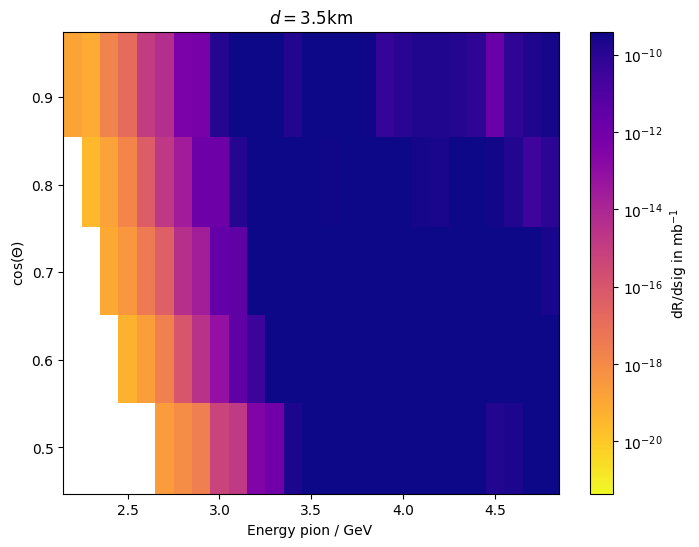

In [49]:
z = np.abs(dRdsig_35_cs101)
plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_values[:-1],  np.cos(np.deg2rad(angle_edges)), z.T, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="dR/dsig in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('cos($\Theta$)')
plt.title('$d=$3.5km')


# Display the plot
plt.savefig(plot_dir + '2D_dRdsig_angle_energy_ebintest_d3.5km.png')
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\T'
<>:24: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_126870/3429716986.py:24: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('cos($\Theta$)')


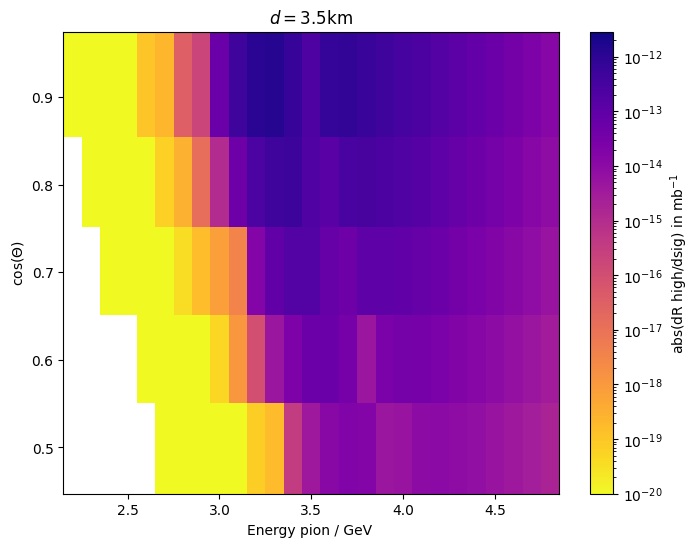

In [50]:
z = np.abs(dRdsig_high_35_cs101)
z_min = 1.e-20
z_max = np.max(z)


# Calculate the first and last bin edges
angle_edges = np.zeros(len(angles) + 1)
angle_edges[0] = angles[0] - (angles[1] - angles[0]) / 2
angle_edges[-1] = angles[-1] + (angles[-1] - angles[-2]) / 2

# Calculate edges for the interior bins
for i in range(1, len(angles)):
    angle_edges[i] = (angles[i-1] + angles[i]) / 2

plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_values[:-1],  np.cos(np.deg2rad(angle_edges)), z.T, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dR high/dsig) in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('cos($\Theta$)')
plt.title('$d=$3.5km')


# Display the plot
plt.savefig(plot_dir + '2D_dRhighdsig_angle_energy_ebintest_csp1.01_d3.5km.png')
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\T'
<>:24: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_126870/386170429.py:24: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('cos($\Theta$)')


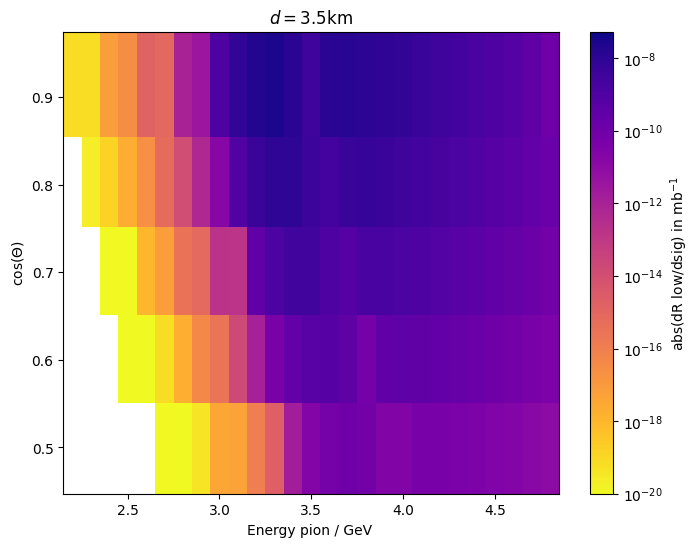

In [51]:
z = np.abs(dRdsig_low_35_cs101)
z_min = 1.e-20#np.min(z)
z_max = np.max(z)


# Calculate the first and last bin edges
angle_edges = np.zeros(len(angles) + 1)
angle_edges[0] = angles[0] - (angles[1] - angles[0]) / 2
angle_edges[-1] = angles[-1] + (angles[-1] - angles[-2]) / 2

# Calculate edges for the interior bins
for i in range(1, len(angles)):
    angle_edges[i] = (angles[i-1] + angles[i]) / 2

plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_values[:-1],  np.cos(np.deg2rad(angle_edges)), z.T, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dR low/dsig) in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('cos($\Theta$)')
plt.title('$d=$3.5km')


# Display the plot
plt.savefig(plot_dir + '2D_dRlowdsig_angle_energy_ebintest_csp1.01_d3.5km.png')
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\T'
<>:24: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_126870/3722509045.py:24: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('cos($\Theta$)')


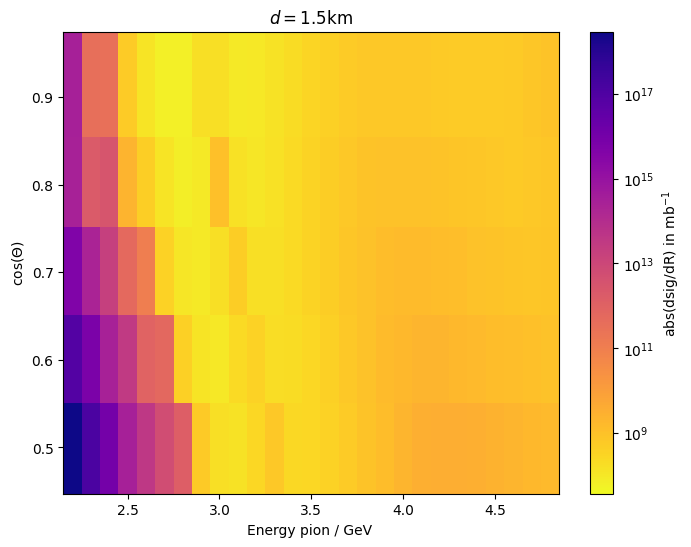

In [52]:
z = np.abs(dRdsig_15_cs101**(-1))
z_min = np.min(z)
z_max = np.max(z)


# Calculate the first and last bin edges
angle_edges = np.zeros(len(angles) + 1)
angle_edges[0] = angles[0] - (angles[1] - angles[0]) / 2
angle_edges[-1] = angles[-1] + (angles[-1] - angles[-2]) / 2

# Calculate edges for the interior bins
for i in range(1, len(angles)):
    angle_edges[i] = (angles[i-1] + angles[i]) / 2

plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_values[:-1],  np.cos(np.deg2rad(angle_edges)), z.T, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dsig/dR) in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('cos($\Theta$)')
plt.title('$d=$1.5km')


# Display the plot
plt.savefig(plot_dir + '2D_dsigdR_angle_energy_ebintest_d1.5km.png')
plt.show()


<>:24: SyntaxWarning: invalid escape sequence '\T'
<>:24: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_126870/1164393302.py:24: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('cos($\Theta$)')


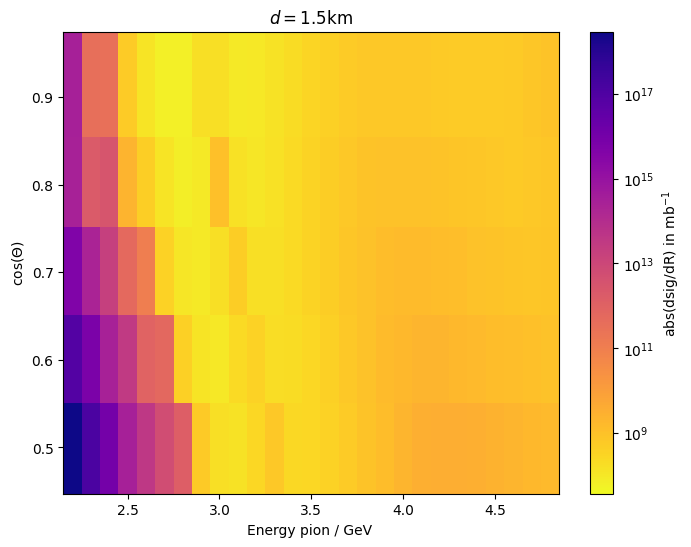

In [53]:
z = np.abs(dRdsig_15_cs101**(-1))
z_min = np.min(z)
z_max = np.max(z)


# Calculate the first and last bin edges
angle_edges = np.zeros(len(angles) + 1)
angle_edges[0] = angles[0] - (angles[1] - angles[0]) / 2
angle_edges[-1] = angles[-1] + (angles[-1] - angles[-2]) / 2

# Calculate edges for the interior bins
for i in range(1, len(angles)):
    angle_edges[i] = (angles[i-1] + angles[i]) / 2

plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_values[:-1],  np.cos(np.deg2rad(angle_edges)), z.T, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dsig/dR) in mb$^{-1}$", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('cos($\Theta$)')
plt.title('$d=$1.5km')


# Display the plot
plt.savefig(plot_dir + '2D_dsigdR_angle_energy_ebintest_d1.5km.png')
plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\T'
<>:13: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_126870/1989452457.py:13: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('cos($\Theta$)')
/tmp/ipykernel_126870/1989452457.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  z = np.abs(dRdsig_35_cs101**(-1))


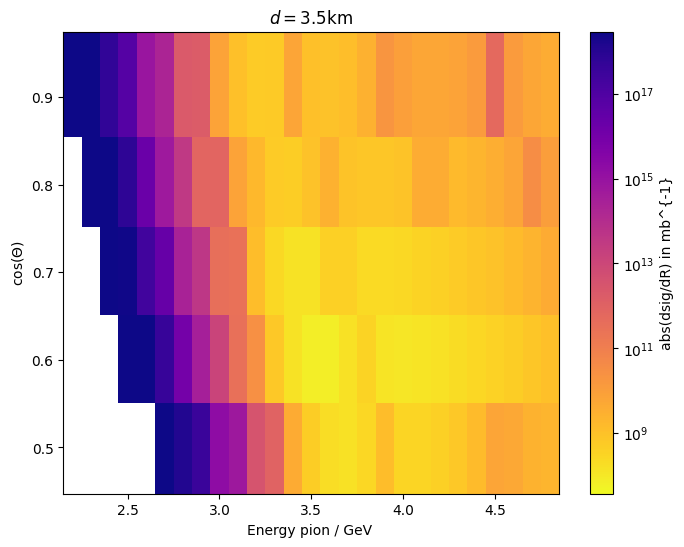

In [54]:
z = np.abs(dRdsig_35_cs101**(-1))


plt.figure(figsize=(8, 6))
plt.pcolormesh(e0_values[:-1],  np.cos(np.deg2rad(angle_edges)), z.T, cmap='plasma_r', 
               norm=LogNorm(vmin=z_min, vmax=z_max), shading='auto')

# Add color bar with logarithmic scale and set the min/max values
cbar = plt.colorbar(label="abs(dsig/dR) in mb^{-1}", norm=LogNorm(vmin=z_min, vmax=z_max))

# Set labels
plt.xlabel('Energy pion / GeV ')
plt.ylabel('cos($\Theta$)')
plt.title('$d=$3.5km')

# Display the plot
plt.savefig(plot_dir + '2D_dsigdR_angle_energy_ebintest_d3.5km.png')
plt.show()